### Goal 
    Schuster would like to better understand the customers’ payment behaviour based on their past payment patterns (customer segmentation).
    Using historical information, it wants to be able to predict the likelihood of delayed payment against open invoices from its customers.
    It wants to use this information so that collectors can prioritise their work in following up with customers beforehand to get the payments on time.


### Steps towards the Solution
    1. Importing libraries and Understanding the Data
    2. Data Cleaning
    3. Data Visualisation
    4. Customer Segmentation(based on past pattern)
    5. Dealing with the Data Imbalance
    6. Model Building LR, Random Forest
    7. Prediction on test data
    8. Model prediction/deployment on open invoices 
    10. Insights

## 1. Importing libraries and Understanding the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_columns',120)
pd.set_option('display.max_rows',120)

### Reading the 2 data sets

In [2]:
rec_pay_data = pd.read_csv('Received_Payments_Data.csv')
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [3]:
rec_pay_data.shape

(93937, 16)

In [4]:
op_inv_data = pd.read_csv('Open_Invoice_data.csv',encoding='unicode_escape')
op_inv_data.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [5]:
op_inv_data.shape

(88204, 14)

In [6]:
# first we have to work on payments received data as this data will help in creating the model
# so for now we are working on the rec_pay_data

In [7]:
### Checking for missing values in the data
rec_pay_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [8]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [9]:
# Checking for duplicate rows
duplicate = rec_pay_data[rec_pay_data.duplicated()]
duplicate.head(10)

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
7,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.0,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
8,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.0,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
9,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.0,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
11,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.0,41991.60971,99200000040,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
26,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000032,31-Oct-20,15-Dec-20,45 Days from EOM,INV,SAR,Non Goods
27,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000029,29-Sep-20,15-Nov-20,45 Days from EOM,INV,SAR,Non Goods
29,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000023,31-Jul-20,15-Sep-20,45 Days from EOM,INV,SAR,Non Goods
30,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000020,1-Jul-20,15-Aug-20,45 Days from EOM,INV,SAR,Non Goods
31,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000032,31-Oct-20,15-Dec-20,45 Days from EOM,INV,SAR,Non Goods
32,WIRE,HAVA Corp,20884,9.921000e+10,31-May-21,PMT,SAR,113000.0,30127.31364,99200000029,29-Sep-20,15-Nov-20,45 Days from EOM,INV,SAR,Non Goods


In [10]:
# Checking for the number of duplicate rows
rec_pay_data.duplicated().sum()

51037

In [11]:
# Removing the duplicate rows from the df
rec_pay_data = rec_pay_data[~rec_pay_data.duplicated()]
rec_pay_data.shape

(42900, 16)

In [12]:
# missing value treatment

rec_pay_data.isnull().sum()/len(rec_pay_data)

RECEIPT_METHOD           0.000000
CUSTOMER_NAME            0.000000
CUSTOMER_NUMBER          0.000000
RECEIPT_DOC_NO           0.000396
RECEIPT_DATE             0.000000
CLASS                    0.000000
CURRENCY_CODE            0.000000
Local Amount             0.000000
USD Amount               0.000000
INVOICE_ALLOCATED        0.000000
INVOICE_CREATION_DATE    0.000000
DUE_DATE                 0.000000
PAYMENT_TERM             0.000000
INVOICE_CLASS            0.000000
INVOICE_CURRENCY_CODE    0.000000
INVOICE_TYPE             0.000000
dtype: float64

In [13]:
# As the colum receipt_doc_no has very few null values, and also the column is of no significance
# we can drop the column
rec_pay_data.drop('RECEIPT_DOC_NO',axis=1, inplace=True)
rec_pay_data.shape

(42900, 15)

In [14]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [15]:
# As it is mentioned, we have to remove invoices with amount <0
# Let's check for invoice amount less than 0(if any present in the DF)
rec_pay_data[rec_pay_data['Local Amount'] <= 0]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
1091,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,15-May-19,15-Jun-19,15 Days from EOM,INV,SAR,Goods
1092,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,6-Aug-19,15-Sep-19,15 Days from EOM,INV,SAR,Goods
1093,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,19-Dec-19,15-Jan-20,15 Days from EOM,INV,SAR,Goods
1094,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,11705,24-Jan-21,15-Feb-21,15 Days from EOM,INV,SAR,Non Goods
1095,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0118E+11,15-Aug-18,15-Sep-18,15 Days from EOM,INV,SAR,Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93879,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006359,28-Jun-20,29-Aug-17,30 Days from Inv Date,INV,SAR,Non Goods
93880,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006467,28-Jun-20,31-Aug-17,30 Days from Inv Date,INV,SAR,Non Goods
93881,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006765,28-Jun-20,6-Sep-17,30 Days from Inv Date,INV,SAR,Non Goods
93882,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006917,28-Jun-20,9-Sep-17,30 Days from Inv Date,INV,SAR,Non Goods


In [16]:
rec_pay_data[rec_pay_data['USD Amount'] <= 0]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
1091,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,15-May-19,15-Jun-19,15 Days from EOM,INV,SAR,Goods
1092,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,6-Aug-19,15-Sep-19,15 Days from EOM,INV,SAR,Goods
1093,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0119E+11,19-Dec-19,15-Jan-20,15 Days from EOM,INV,SAR,Goods
1094,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,11705,24-Jan-21,15-Feb-21,15 Days from EOM,INV,SAR,Non Goods
1095,WIRE,AL F Corp,23618,31-Jan-21,PMT,SAR,0.0,0.0,1.0118E+11,15-Aug-18,15-Sep-18,15 Days from EOM,INV,SAR,Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93879,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006359,28-Jun-20,29-Aug-17,30 Days from Inv Date,INV,SAR,Non Goods
93880,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006467,28-Jun-20,31-Aug-17,30 Days from Inv Date,INV,SAR,Non Goods
93881,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006765,28-Jun-20,6-Sep-17,30 Days from Inv Date,INV,SAR,Non Goods
93882,WIRE,SAUD Corp,38035,31-May-21,PMT,SAR,0.0,0.0,2000006917,28-Jun-20,9-Sep-17,30 Days from Inv Date,INV,SAR,Non Goods


In [17]:
# As suggested, ignoring invoice values less than 0
rec_pay_data = rec_pay_data[rec_pay_data["Local Amount"] > 0]
rec_pay_data.shape

(42058, 15)

In [18]:
# As the local amount has values in different curriencies, we can drop it.
rec_pay_data.CURRENCY_CODE.value_counts(normalize=True)*100

AED    42.650625
SAR    37.609967
USD    18.362737
EUR     1.091350
BHD     0.135527
GBP     0.121261
KWD     0.023777
QAR     0.004755
Name: CURRENCY_CODE, dtype: float64

In [19]:
# As the local amount has values in different curriencies, we can drop it
# We have the value in standard i.e. USD
rec_pay_data.drop('Local Amount', axis=1, inplace=True)
rec_pay_data.shape

(42058, 14)

In [20]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,20-Apr-21,PMT,USD,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,31-Jan-21,PMT,SAR,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,31-Jan-21,PMT,SAR,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [21]:
rec_pay_data.describe()

,CUSTOMER_NUMBER,USD Amount
count,42058.000000,4.205800e+04
mean,16099.881307,3.041674e+05
std,16089.238283,7.109582e+05
min,1044.000000,1.287743e+00
25%,2795.000000,1.579608e+04
50%,7530.000000,6.861197e+04
75%,34161.000000,2.754132e+05
max,52940.000000,1.084983e+07


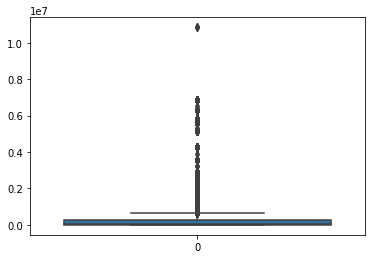

In [22]:
sns.boxplot(rec_pay_data['USD Amount'])
plt.show()

In [23]:
# We can see that there are a number of outliers present in the USD Amount columns
# Let's try to fix this
rec_pay_data['USD Amount'].describe(percentiles=[0,0.25,0.50,0.75,0.9,0.95,0.99,1])

count    4.205800e+04
mean     3.041674e+05
std      7.109582e+05
min      1.287743e+00
0%       1.287743e+00
25%      1.579608e+04
50%      6.861197e+04
75%      2.754132e+05
90%      7.251886e+05
95%      1.224990e+06
99%      4.273780e+06
100%     1.084983e+07
max      1.084983e+07
Name: USD Amount, dtype: float64

In [24]:
# Lets check for values above 99%
rec_pay_data[rec_pay_data['USD Amount']>4500000]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
24177,WIRE,SEPH Corp,2315,27-May-21,PMT,AED,5162944.89,1.4721E+11,17-Mar-21,30-May-21,60 Days from EOM,INV,AED,Goods
24179,WIRE,SEPH Corp,2315,27-May-21,PMT,AED,5162944.89,1.4721E+11,20-Jan-21,30-Mar-21,60 Days from EOM,INV,AED,Goods
24180,WIRE,SEPH Corp,2315,27-May-21,PMT,AED,5162944.89,1.4721E+11,30-Mar-21,30-May-21,60 Days from EOM,INV,AED,Goods
24183,WIRE,SEPH Corp,2315,27-May-21,PMT,AED,5162944.89,1.4721E+11,31-Mar-21,30-May-21,60 Days from EOM,INV,AED,Goods
24185,WIRE,SEPH Corp,2315,27-May-21,PMT,AED,5162944.89,1.4721E+11,10-Feb-21,30-Apr-21,60 Days from EOM,INV,AED,Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63399,WIRE,SEPH Corp,15768,29-Jun-21,PMT,USD,5814128.07,1.5621E+11,6-Apr-21,5-Jun-21,60 Days from Inv Date,INV,USD,Goods
63406,WIRE,SEPH Corp,15768,29-Jun-21,PMT,USD,5814128.07,1.5621E+11,11-Apr-21,10-Apr-21,Immediate Payment,INV,USD,Goods
63407,WIRE,SEPH Corp,15768,29-Jun-21,PMT,USD,5814128.07,1.5621E+11,11-Apr-21,11-Apr-21,Immediate Payment,INV,USD,Goods
68669,WIRE,FUN Corp,1154,22-Mar-21,PMT,USD,6529190.85,1.6821E+11,28-Feb-21,30-Mar-21,30 Days from EOM,INV,USD,Non Goods


In [25]:
# The above values look ok, lets check for some other value
rec_pay_data[rec_pay_data['USD Amount']>7000000]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
60057,WIRE,SEPH Corp,2315,16-Feb-21,PMT,AED,10849828.8,1.5621E+11,3-Jan-21,3-Jan-21,Immediate Payment,INV,AED,Non Goods
60058,WIRE,SEPH Corp,2315,16-Feb-21,PMT,AED,10849828.8,1.5621E+11,14-Feb-21,14-Feb-21,Immediate Payment,INV,AED,Non Goods
60059,WIRE,SEPH Corp,2315,16-Feb-21,PMT,AED,10849828.8,1.5621E+11,26-Jan-21,26-Jan-21,Immediate Payment,INV,AED,Non Goods
60060,WIRE,SEPH Corp,2315,16-Feb-21,PMT,AED,10849828.8,1.5621E+11,12-Jan-21,12-Jan-21,Immediate Payment,INV,AED,Non Goods


In [26]:
# These are only few values above 7M, lets check if SEPH Corp is one of the big customers
rec_pay_data.groupby("CUSTOMER_NAME")["USD Amount"].sum().sort_values(ascending=False)

CUSTOMER_NAME
SEPH Corp    6.153360e+09
ALLI Corp    1.652239e+09
FARO Corp    1.492450e+09
PARF Corp    6.955001e+08
CGR  Corp    2.508334e+08
                 ...     
HEAT Corp    1.633500e+02
PEAC Corp    1.225200e+02
DESI Corp    1.166971e+02
BEX  Corp    7.805310e+01
NOUS Corp    5.065655e+00
Name: USD Amount, Length: 689, dtype: float64

In [27]:
rec_pay_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42058 entries, 0 to 93931
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         42058 non-null  object 
 1   CUSTOMER_NAME          42058 non-null  object 
 2   CUSTOMER_NUMBER        42058 non-null  int64  
 3   RECEIPT_DATE           42058 non-null  object 
 4   CLASS                  42058 non-null  object 
 5   CURRENCY_CODE          42058 non-null  object 
 6   USD Amount             42058 non-null  float64
 7   INVOICE_ALLOCATED      42058 non-null  object 
 8   INVOICE_CREATION_DATE  42058 non-null  object 
 9   DUE_DATE               42058 non-null  object 
 10  PAYMENT_TERM           42058 non-null  object 
 11  INVOICE_CLASS          42058 non-null  object 
 12  INVOICE_CURRENCY_CODE  42058 non-null  object 
 13  INVOICE_TYPE           42058 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 6.1+

In [28]:
# The RECEIPT_DATE, INVOICE_CREATION_DATE AND DUE_DATE all have object format. 
# Lets convert all the 3 date columns to date time

rec_pay_data['RECEIPT_DATE'] = pd.to_datetime(rec_pay_data['RECEIPT_DATE'],format='%d-%b-%y')
rec_pay_data['INVOICE_CREATION_DATE'] = pd.to_datetime(rec_pay_data['INVOICE_CREATION_DATE'],format='%d-%b-%y')
rec_pay_data['DUE_DATE'] = pd.to_datetime(rec_pay_data['DUE_DATE'],format='%d-%b-%y')


In [29]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,2021-04-20,PMT,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,2021-01-31,PMT,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [30]:
# checking the datatypes once again 
rec_pay_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42058 entries, 0 to 93931
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         42058 non-null  object        
 1   CUSTOMER_NAME          42058 non-null  object        
 2   CUSTOMER_NUMBER        42058 non-null  int64         
 3   RECEIPT_DATE           42058 non-null  datetime64[ns]
 4   CLASS                  42058 non-null  object        
 5   CURRENCY_CODE          42058 non-null  object        
 6   USD Amount             42058 non-null  float64       
 7   INVOICE_ALLOCATED      42058 non-null  object        
 8   INVOICE_CREATION_DATE  42058 non-null  datetime64[ns]
 9   DUE_DATE               42058 non-null  datetime64[ns]
 10  PAYMENT_TERM           42058 non-null  object        
 11  INVOICE_CLASS          42058 non-null  object        
 12  INVOICE_CURRENCY_CODE  42058 non-null  object        
 13  I

In [31]:
rec_pay_data.shape

(42058, 14)

In [32]:
# Now let's check each all the variables one by one 
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,2021-04-20,PMT,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,2021-01-31,PMT,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,2021-01-31,PMT,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [33]:
# Receipt Method
rec_pay_data.RECEIPT_METHOD.value_counts(normalize=True)*100

WIRE             86.230919
AP/AR Netting     6.802511
CHEQUE            4.752960
CASH              1.531219
PDC               0.392315
I/C WIRE          0.273432
I/C Check         0.011888
I/C CASH          0.004755
Name: RECEIPT_METHOD, dtype: float64

In [34]:
# Majority payments are made on wire mode

In [35]:
rec_pay_data.CUSTOMER_NAME.value_counts()

SEPH Corp    4945
FARO Corp    4177
ALLI Corp    3580
PARF Corp    2409
YOUG Corp    1480
             ... 
RASH Corp       1
BRAV Corp       1
DARE Corp       1
JUMB Corp       1
MOUJ Corp       1
Name: CUSTOMER_NAME, Length: 689, dtype: int64

In [36]:
rec_pay_data.CUSTOMER_NAME.nunique()

689

In [37]:
rec_pay_data.CUSTOMER_NUMBER.value_counts()

1409     3938
7530     3352
15768    2271
2315     1698
34870    1480
         ... 
51520       1
47120       1
49601       1
51840       1
35005       1
Name: CUSTOMER_NUMBER, Length: 1048, dtype: int64

In [38]:
rec_pay_data.CUSTOMER_NUMBER.nunique()

1048

In [39]:
# CUSTOMER NUMBER IS NOT IMPORTANT FOR OUR ANALYSIS SO WE CAN DROP THIS COLUMN
rec_pay_data.groupby("CUSTOMER_NUMBER")["USD Amount"].sum().sort_values(ascending=False)

CUSTOMER_NUMBER
15768    3.019642e+09
2315     2.757898e+09
7530     1.613342e+09
1409     1.459521e+09
1888     4.409704e+08
             ...     
3771     1.166971e+02
4650     1.089176e+02
52580    7.805310e+01
48681    5.990470e+01
35110    5.065655e+00
Name: USD Amount, Length: 1048, dtype: float64

In [40]:
rec_pay_data.groupby("CUSTOMER_NAME")["USD Amount"].sum().sort_values(ascending=False)

CUSTOMER_NAME
SEPH Corp    6.153360e+09
ALLI Corp    1.652239e+09
FARO Corp    1.492450e+09
PARF Corp    6.955001e+08
CGR  Corp    2.508334e+08
                 ...     
HEAT Corp    1.633500e+02
PEAC Corp    1.225200e+02
DESI Corp    1.166971e+02
BEX  Corp    7.805310e+01
NOUS Corp    5.065655e+00
Name: USD Amount, Length: 689, dtype: float64

In [41]:
rec_pay_data.groupby(["CUSTOMER_NAME","CUSTOMER_NUMBER"])['USD Amount'].sum().sort_values(ascending=False)

CUSTOMER_NAME  CUSTOMER_NUMBER
SEPH Corp      15768              3.019642e+09
               2315               2.757898e+09
ALLI Corp      7530               1.613342e+09
FARO Corp      1409               1.459521e+09
PARF Corp      1888               4.409704e+08
                                      ...     
DESI Corp      3771               1.166971e+02
LOUI Corp      4650               1.089176e+02
BEX  Corp      52580              7.805310e+01
FORE Corp      48681              5.990470e+01
NOUS Corp      35110              5.065655e+00
Name: USD Amount, Length: 1048, dtype: float64

In [42]:
rec_pay_data.groupby(["CUSTOMER_NUMBER"])['USD Amount'].sum().sort_values(ascending=False)

CUSTOMER_NUMBER
15768    3.019642e+09
2315     2.757898e+09
7530     1.613342e+09
1409     1.459521e+09
1888     4.409704e+08
             ...     
3771     1.166971e+02
4650     1.089176e+02
52580    7.805310e+01
48681    5.990470e+01
35110    5.065655e+00
Name: USD Amount, Length: 1048, dtype: float64

In [43]:
rec_pay_data.groupby(["CUSTOMER_NAME"])['USD Amount'].sum().sort_values(ascending=False)

CUSTOMER_NAME
SEPH Corp    6.153360e+09
ALLI Corp    1.652239e+09
FARO Corp    1.492450e+09
PARF Corp    6.955001e+08
CGR  Corp    2.508334e+08
                 ...     
HEAT Corp    1.633500e+02
PEAC Corp    1.225200e+02
DESI Corp    1.166971e+02
BEX  Corp    7.805310e+01
NOUS Corp    5.065655e+00
Name: USD Amount, Length: 689, dtype: float64

In [44]:
# We can drop the Column Customer Number as it is not imp for the analysis
rec_pay_data.drop('CUSTOMER_NUMBER',axis=1,inplace=True)
rec_pay_data.shape

(42058, 13)

In [45]:
rec_pay_data.groupby(["CUSTOMER_NAME"])['USD Amount'].sum().sort_values(ascending=False).head()

CUSTOMER_NAME
SEPH Corp    6.153360e+09
ALLI Corp    1.652239e+09
FARO Corp    1.492450e+09
PARF Corp    6.955001e+08
CGR  Corp    2.508334e+08
Name: USD Amount, dtype: float64

In [46]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CLASS,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,2021-04-20,PMT,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,2021-01-31,PMT,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,2021-01-31,PMT,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,2021-01-31,PMT,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,2021-01-31,PMT,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [47]:
rec_pay_data.CLASS.value_counts()

PMT    42058
Name: CLASS, dtype: int64

In [48]:
# Since all the values in the Class column are PMT we can drop this column
rec_pay_data.drop('CLASS',axis=1,inplace=True)
rec_pay_data.shape

(42058, 12)

In [49]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [50]:
rec_pay_data.INVOICE_CLASS.value_counts()

INV    39252
CM      2719
DM        87
Name: INVOICE_CLASS, dtype: int64

In [51]:
# Checking for the payment terms
rec_pay_data.groupby(['CUSTOMER_NAME','PAYMENT_TERM'])['USD Amount'].sum().sort_values(ascending=False)

CUSTOMER_NAME  PAYMENT_TERM         
SEPH Corp      Immediate Payment        1.946815e+09
               60 Days from Inv Date    1.657258e+09
ALLI Corp      30 Days from EOM         1.091027e+09
SEPH Corp      Immediate                7.930745e+08
               30 Days from Inv Date    7.740826e+08
                                            ...     
BEX  Corp      30 Days from Inv Date    7.805310e+01
FORE Corp      30 Days from EOM         5.990470e+01
CAMI Corp      100% Adv Payment         3.528000e+01
C EA Corp      30 Days from Inv Date    1.057862e+01
NOUS Corp      25 DAYS FROM EOM         5.065655e+00
Name: USD Amount, Length: 1584, dtype: float64

In [52]:
rec_pay_data.groupby(['CUSTOMER_NAME','PAYMENT_TERM'])['USD Amount'].count().sort_values(ascending=False)

CUSTOMER_NAME  PAYMENT_TERM         
ALLI Corp      30 Days from EOM         2077
SEPH Corp      60 Days from Inv Date    1774
PARF Corp      30 Days from Inv Date    1684
YOUG Corp      Immediate Payment        1480
FARO Corp      15 Days from EOM         1119
                                        ... 
JOMA Corp      45 Days from Inv Date       1
JOEY Corp      Immediate Payment           1
BASI Corp      Immediate                   1
JIZA Corp      100% Adv Payment            1
ZV F Corp      45 Days from Inv Date       1
Name: USD Amount, Length: 1584, dtype: int64

In [53]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [54]:
# The Invoice Allocated coulumn is also of no use in prediction so can be dropped
rec_pay_data.drop('INVOICE_ALLOCATED',axis=1,inplace=True)
rec_pay_data.shape

(42058, 11)

In [55]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [56]:
rec_pay_data.PAYMENT_TERM.value_counts(normalize=True)*100

30 Days from EOM                                           20.600124
30 Days from Inv Date                                      18.013220
60 Days from Inv Date                                      12.713396
Immediate Payment                                           8.723667
60 Days from EOM                                            7.016501
15 Days from EOM                                            6.500547
Immediate                                                   6.464882
45 Days from Inv Date                                       5.311712
90 Days from EOM                                            3.754339
90 Days from Inv Date                                       2.503685
45 Days from EOM                                            2.220743
100% Adv Payment                                            1.773741
25 DAYS FROM EOM                                            0.767987
45 DAYS + EOM                                               0.634838
15 Days from Inv Date             

In [57]:
# we can club immediate and immediate payment, 45 days from EOM and 45 days + EOM
rec_pay_data['PAYMENT_TERM'] = rec_pay_data.PAYMENT_TERM.replace(['Immediate Payment'],'Immediate')
rec_pay_data['PAYMENT_TERM'] = rec_pay_data.PAYMENT_TERM.replace(['45 Days + EOM'],'45 Days from EOM')

In [58]:
rec_pay_data.PAYMENT_TERM.value_counts(normalize=True)*100

30 Days from EOM                                           20.600124
30 Days from Inv Date                                      18.013220
Immediate                                                  15.188549
60 Days from Inv Date                                      12.713396
60 Days from EOM                                            7.016501
15 Days from EOM                                            6.500547
45 Days from Inv Date                                       5.311712
90 Days from EOM                                            3.754339
90 Days from Inv Date                                       2.503685
45 Days from EOM                                            2.220743
100% Adv Payment                                            1.773741
25 DAYS FROM EOM                                            0.767987
45 DAYS + EOM                                               0.634838
15 Days from Inv Date                                       0.627705
Cash on Delivery                  

In [59]:
rec_pay_data.PAYMENT_TERM.value_counts(normalize=True).cumsum()*100

30 Days from EOM                                            20.600124
30 Days from Inv Date                                       38.613343
Immediate                                                   53.801893
60 Days from Inv Date                                       66.515288
60 Days from EOM                                            73.531789
15 Days from EOM                                            80.032336
45 Days from Inv Date                                       85.344049
90 Days from EOM                                            89.098388
90 Days from Inv Date                                       91.602073
45 Days from EOM                                            93.822816
100% Adv Payment                                            95.596557
25 DAYS FROM EOM                                            96.364544
45 DAYS + EOM                                               96.999382
15 Days from Inv Date                                       97.627086
Cash on Delivery    

In [60]:
keep_value = rec_pay_data.PAYMENT_TERM.value_counts(normalize=True).index[:11]
rec_pay_data['PAYMENT_TERM'] = rec_pay_data['PAYMENT_TERM'].apply(lambda x : x if x in keep_value else 'Others')

In [61]:
rec_pay_data.PAYMENT_TERM.value_counts(normalize=True)*100

30 Days from EOM         20.600124
30 Days from Inv Date    18.013220
Immediate                15.188549
60 Days from Inv Date    12.713396
60 Days from EOM          7.016501
15 Days from EOM          6.500547
45 Days from Inv Date     5.311712
Others                    4.403443
90 Days from EOM          3.754339
90 Days from Inv Date     2.503685
45 Days from EOM          2.220743
100% Adv Payment          1.773741
Name: PAYMENT_TERM, dtype: float64

In [62]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods


In [63]:
# Looking at Invoice Class
rec_pay_data.INVOICE_CLASS.value_counts()

INV    39252
CM      2719
DM        87
Name: INVOICE_CLASS, dtype: int64

In [64]:
# Creating the target column
rec_pay_data['TARGET'] = (rec_pay_data['RECEIPT_DATE']>rec_pay_data['DUE_DATE']).astype(int)
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1


In [65]:
# 1 referes to the over-due, 0 referes within due date

In [66]:
np.round(rec_pay_data['TARGET'].value_counts(normalize=True)*100,1)

1    63.9
0    36.1
Name: TARGET, dtype: float64

In [67]:
# As we have to do customer segmentation based on Payment time, we will have to create the feature
rec_pay_data['PAYMENT_IN_DAYS'] = (rec_pay_data['RECEIPT_DATE'] - rec_pay_data['DUE_DATE']).dt.days
rec_pay_data.head()


,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17


In [68]:
# negative values indicate that the payment was done in advance, positive values indicate
# there was a delay in payments
# checking the payment_in_days column
rec_pay_data['PAYMENT_IN_DAYS'].describe()

count    42058.000000
mean        78.830591
std        220.199745
min       -340.000000
25%         -6.000000
50%         15.000000
75%         54.000000
max       3873.000000
Name: PAYMENT_IN_DAYS, dtype: float64

In [69]:
# Deriving INVOICE_MONTH feature using the INVOICE_CREATION_DATE

rec_pay_data['INVOICE_MONTH'] = rec_pay_data['INVOICE_CREATION_DATE'].dt.month
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12


In [70]:
# Deriving INVOICE_YEAR feature using the INVOICE_CREATION_DATE

rec_pay_data['INVOICE_YEAR'] = rec_pay_data['INVOICE_CREATION_DATE'].dt.year
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11,2020
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12,2020
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1,2021
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020


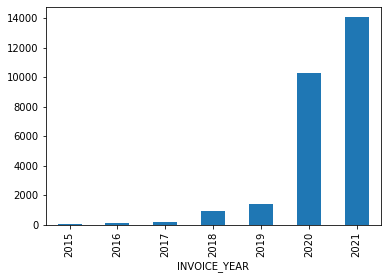

In [71]:
# Let's look at the pending payment year wise
rec_pay_data.groupby(['INVOICE_YEAR'])['TARGET'].sum().plot.bar()
plt.show()

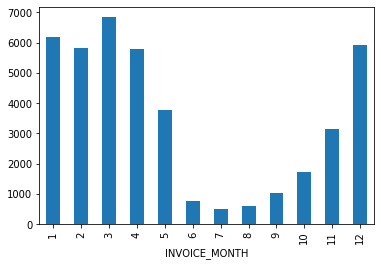

In [72]:
# checking the number month wise
rec_pay_data.groupby(['INVOICE_MONTH'])['TARGET'].count().plot.bar()
plt.show()

In [73]:
# Deriving due month from the due date column
rec_pay_data['DUE_MONTH'] = rec_pay_data['DUE_DATE'].dt.month
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR,DUE_MONTH
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11,2020,12
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12,2020,1
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1,2021,3
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1


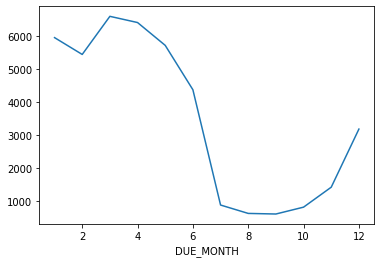

In [74]:
# plot for the due moth to see which month has the most number of invoices
rec_pay_data.groupby(['DUE_MONTH'])['TARGET'].count().plot()
plt.show()

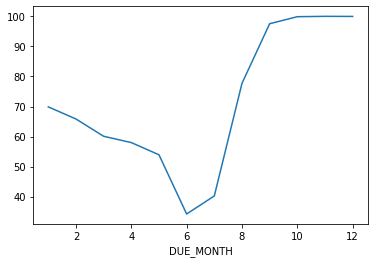

In [75]:
(rec_pay_data.groupby(['DUE_MONTH'])['TARGET'].mean()*100).plot()
plt.show()

In [76]:
# Let us check if day of the week has any effect on the dealys in payments 
rec_pay_data['DUE_DAY'] = rec_pay_data['DUE_DATE'].dt.weekday
rec_pay_data['INVOICE_DAY'] = rec_pay_data['INVOICE_CREATION_DATE'].dt.weekday
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR,DUE_MONTH,DUE_DAY,INVOICE_DAY
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11,2020,12,2,0
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12,2020,1,3,1
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1,2021,3,0,5
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1,3,1
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1,3,1


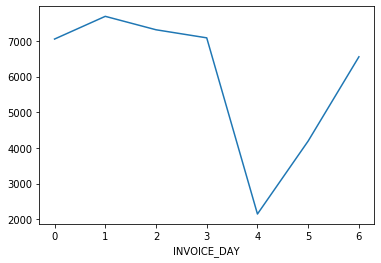

In [77]:
rec_pay_data.groupby('INVOICE_DAY')['TARGET'].count().plot()
plt.show()
# very few invoices are raised on Friday

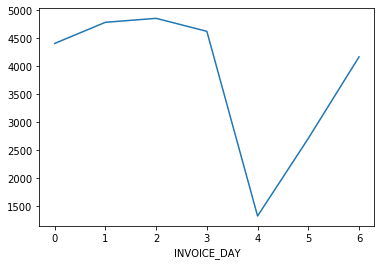

In [78]:
rec_pay_data.groupby('INVOICE_DAY')['TARGET'].sum().plot()
plt.show()

### Categorising the Variables

In [79]:
rec_pay_data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR,DUE_MONTH,DUE_DAY,INVOICE_DAY
0,WIRE,C EA Corp,2021-04-20,USD,101018.63040,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11,2020,12,2,0
1,WIRE,RADW Corp,2021-01-31,SAR,48990.21133,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12,2020,1,3,1
2,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1,2021,3,0,5
3,WIRE,FARO Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1,3,1
4,WIRE,RADW Corp,2021-01-31,SAR,41991.60971,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,1,17,12,2020,1,3,1


In [80]:
rec_pay_data.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'CURRENCY_CODE',
       'USD Amount', 'INVOICE_CREATION_DATE', 'DUE_DATE', 'PAYMENT_TERM',
       'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE', 'INVOICE_TYPE', 'TARGET',
       'PAYMENT_IN_DAYS', 'INVOICE_MONTH', 'INVOICE_YEAR', 'DUE_MONTH',
       'DUE_DAY', 'INVOICE_DAY'],
      dtype='object')

In [81]:
cat_var = ['RECEIPT_METHOD','CURRENCY_CODE','PAYMENT_TERM','INVOICE_CLASS','INVOICE_CURRENCY_CODE',
          'INVOICE_TYPE']
num_var = ['USD Amount','TARGET','PAYMENT_IN_DAYS', 'INVOICE_MONTH', 'INVOICE_YEAR', 'DUE_MONTH',
       'DUE_DAY', 'INVOICE_DAY']
oth_var = ['CUSTOMER_NAME','RECEIPT_DATE','INVOICE_CREATION_DATE','DUE_DATE']

## 3. Data Visualization

In [82]:
# Univariate Analaysis

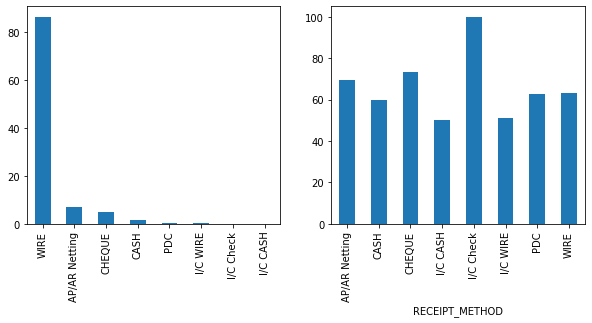

In [83]:
# Checking for Receipt Method
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['RECEIPT_METHOD'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('RECEIPT_METHOD')['TARGET'].mean()*100).plot.bar()

plt.show()

In [84]:
# Max amount is received through Wire and max delay is in I/C Check

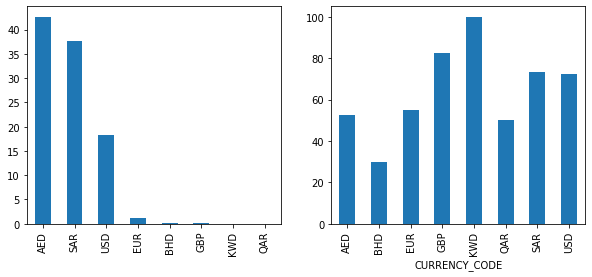

In [85]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['CURRENCY_CODE'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('CURRENCY_CODE')['TARGET'].mean()*100).plot.bar()

plt.show()

In [86]:
# Max amount is received in AED and Max dealy in payment is in KWD

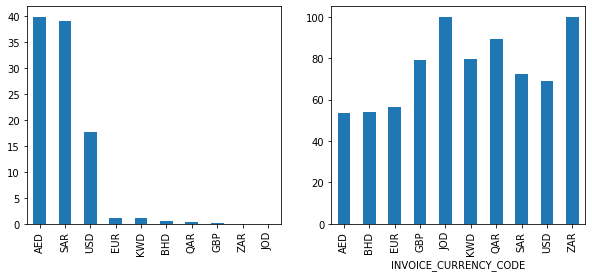

In [87]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['INVOICE_CURRENCY_CODE'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('INVOICE_CURRENCY_CODE')['TARGET'].mean()*100).plot.bar()

plt.show()

In [88]:
# Max delay in invoice currency is from JOD and ZAR

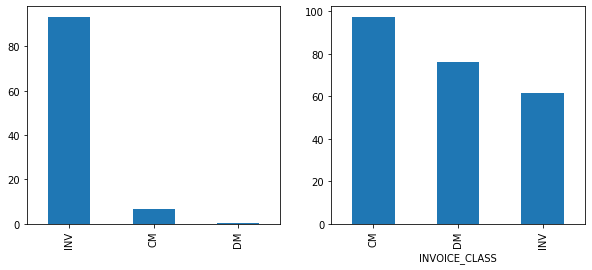

In [89]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['INVOICE_CLASS'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('INVOICE_CLASS')['TARGET'].mean()*100).plot.bar()

plt.show()

In [90]:
# Max delay is in Credit Memeo although their number is very few 

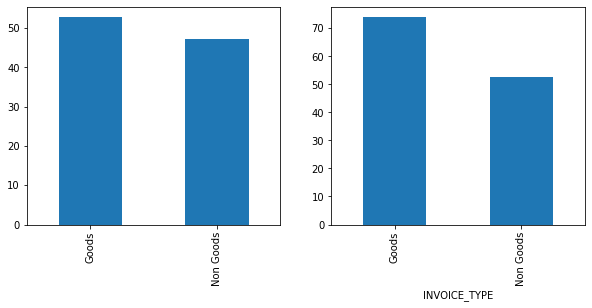

In [91]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['INVOICE_TYPE'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('INVOICE_TYPE')['TARGET'].mean()*100).plot.bar()

plt.show()

In [92]:
# Not much to be inferred here

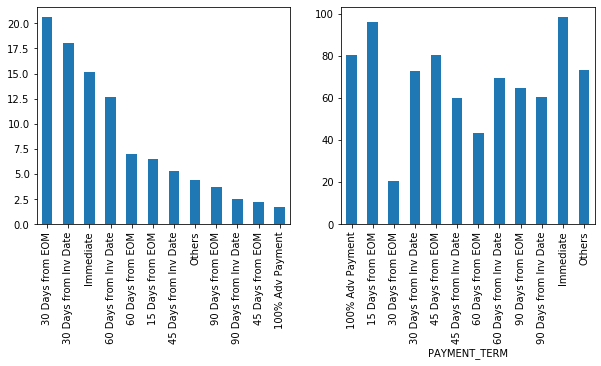

In [93]:
plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
(rec_pay_data['PAYMENT_TERM'].value_counts(normalize=True)*100).plot.bar()


plt.subplot(1,2,2)
(rec_pay_data.groupby('PAYMENT_TERM')['TARGET'].mean()*100).plot.bar()

plt.show()

In [94]:
# Max are from 30 days from EOM and most delays are from 15 days from EOM and Immediate

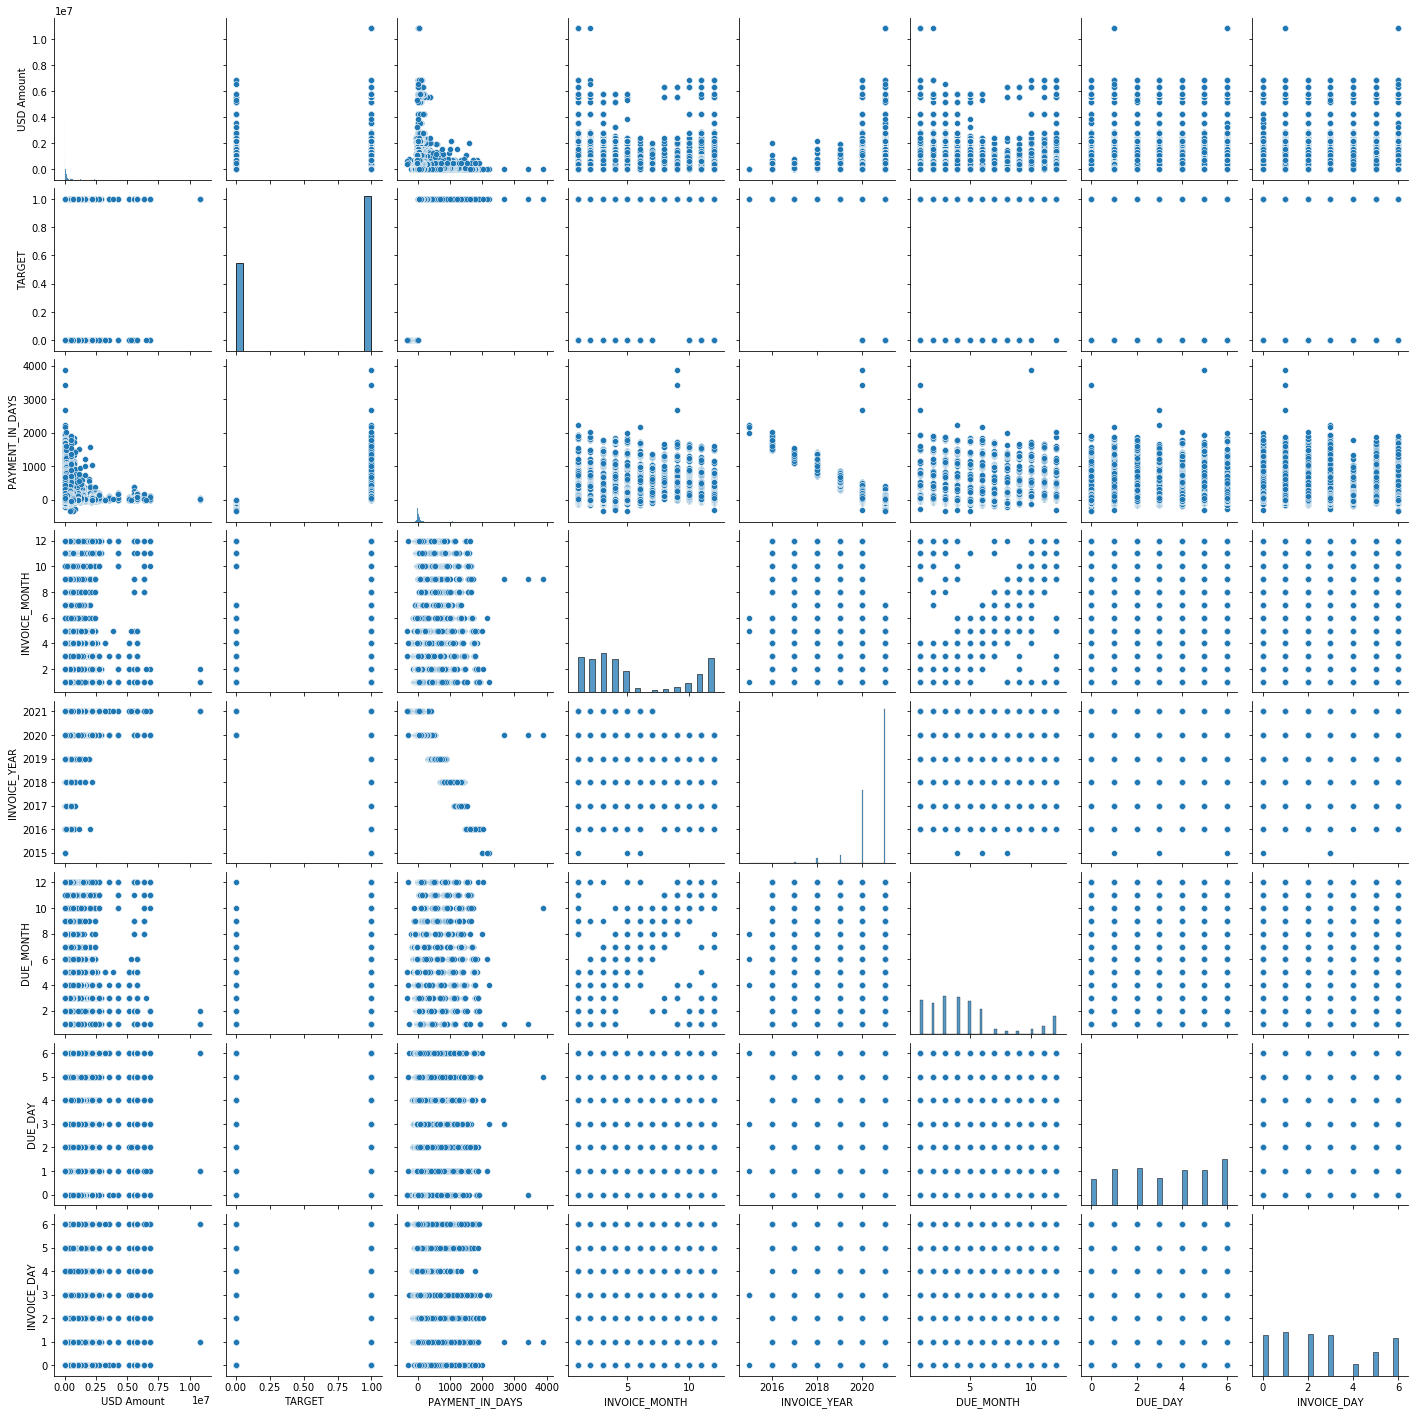

In [95]:
# Bivariate Analysis for the data 
sns.pairplot(data=rec_pay_data,vars=num_var)
plt.show()

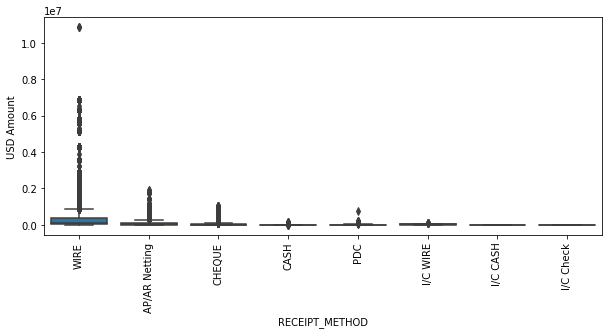

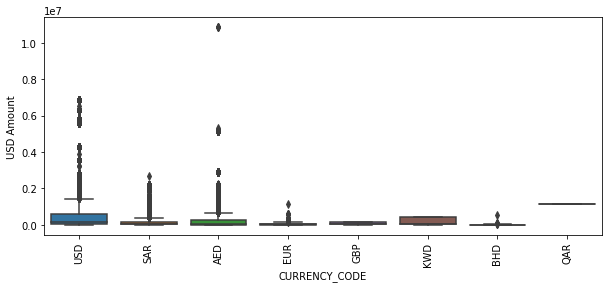

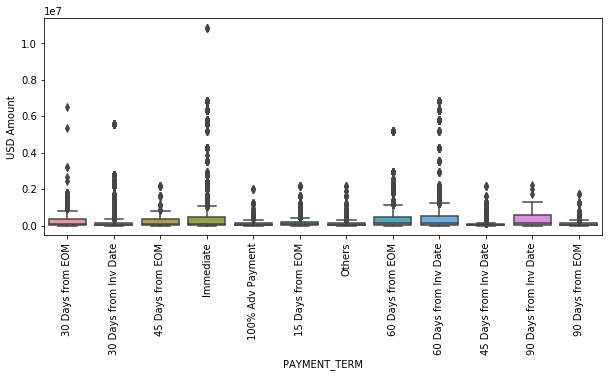

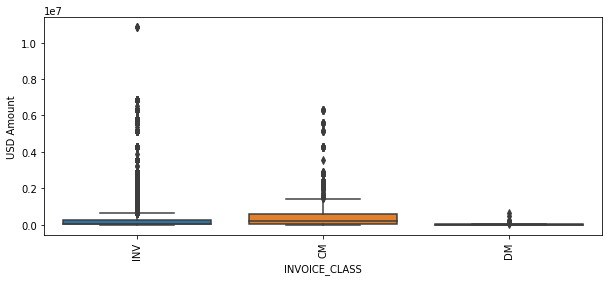

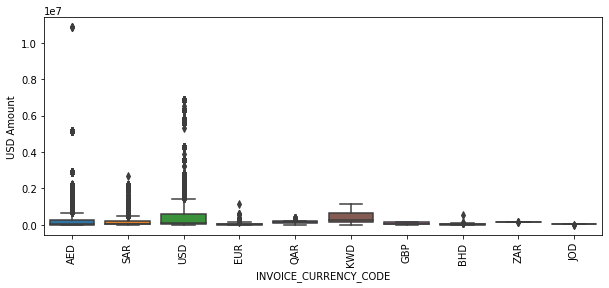

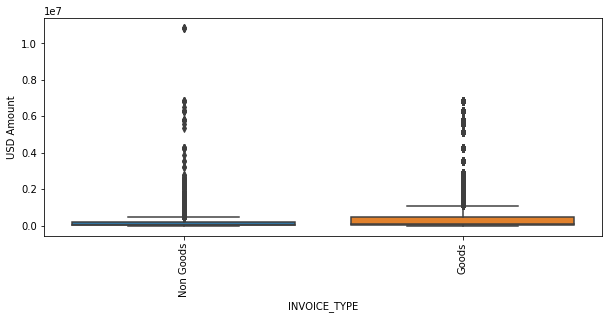

In [103]:
# Bivariate Analysis Between Cat and Target 
for i in cat_var:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=rec_pay_data,x=i,y='USD Amount')
    plt.xticks(rotation=90)
    plt.show()

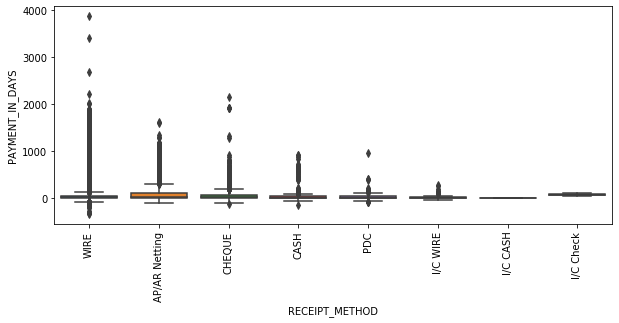

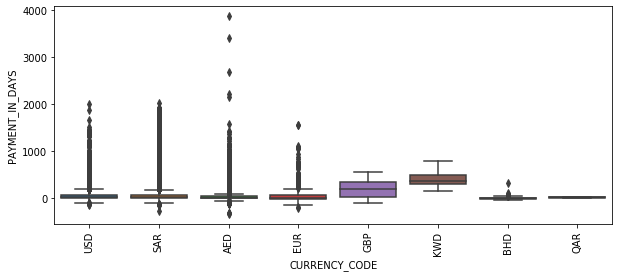

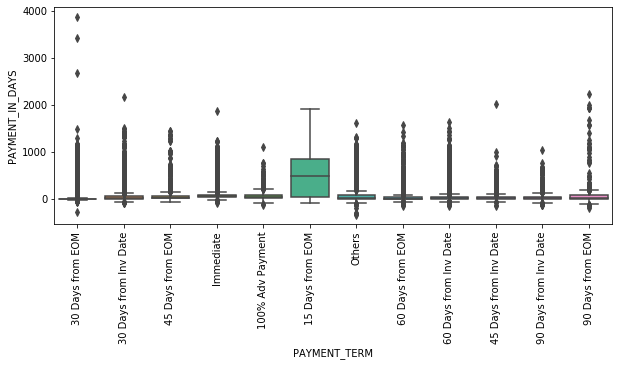

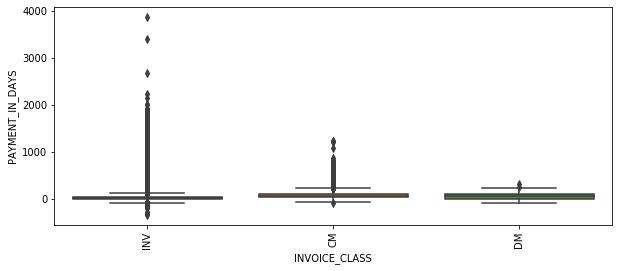

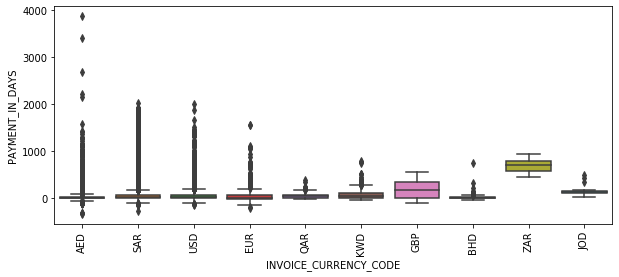

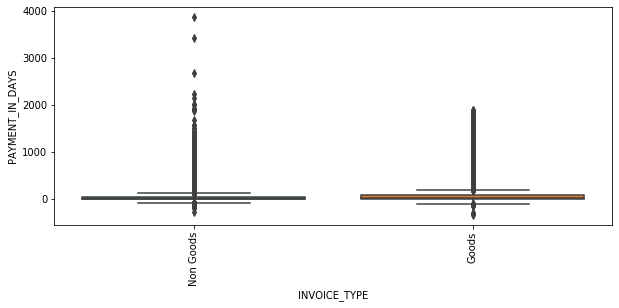

In [102]:
for i in cat_var:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=rec_pay_data,x=i,y='PAYMENT_IN_DAYS')
    plt.xticks(rotation=90)
    plt.show()

### Multivariate Analysis

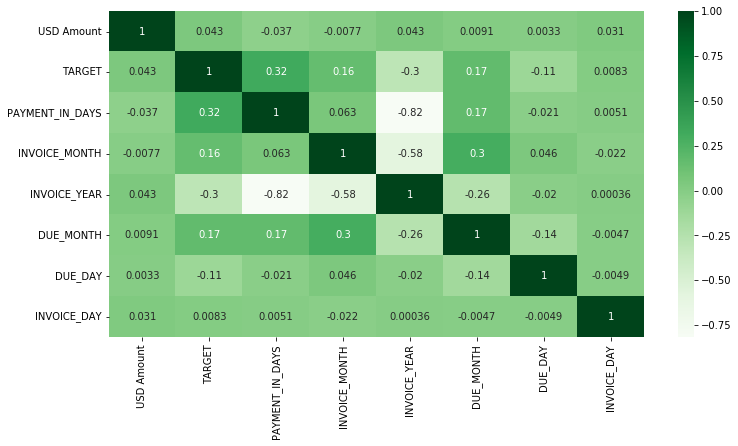

In [107]:
# Checking the correlation between the numeric variables
plt.figure(figsize=(12,6))
sns.heatmap(data=rec_pay_data[num_var].corr(),annot=True, cmap='Greens')
plt.show()

### Points to Note
    -Preferred mode of Payment is WIRE, default is max for I/C check
    -Invoices are mostly raised in AED,SAR & delay rate is high for JOD,ZAR
    -Some invoices are as late as 2015
    -Jul to Sep invoices are considered to have dealy in payments
    -Monday and Thursday invoices have not been paid on time
    -Very less invoices are raised on Friday
    

## 4. Segmentation of CX

### Data Prep

In [108]:
# Creating the first variable for customer segmentation - Average Patment time in days
cust_seg_1 = rec_pay_data.groupby(['CUSTOMER_NAME'])['PAYMENT_IN_DAYS'].mean()
cust_seg_1 = pd.DataFrame(cust_seg_1)
cust_seg_1.reset_index
cust_seg_1.rename(columns={'PAYMENT_IN_DAYS':'AVG_PAY_DAYS'},inplace= True)
cust_seg_1.head()

,AVG_PAY_DAYS
CUSTOMER_NAME,
3D D Corp,-8.681529
6TH Corp,-42.666667
A3 D Corp,28.000000
ABC Corp,-74.000000
ABDU Corp,3.473118


In [109]:
# Creating the second variable for customer segmentation - STD Deviation Payment time 
cust_seg_2 = rec_pay_data.groupby(['CUSTOMER_NAME'])['PAYMENT_IN_DAYS'].std()
cust_seg_2 = pd.DataFrame(cust_seg_2)
cust_seg_2.reset_index
cust_seg_2.rename(columns={'PAYMENT_IN_DAYS':'STD_PAY_DAYS'},inplace= True)
cust_seg_2.head()

,STD_PAY_DAYS
CUSTOMER_NAME,
3D D Corp,17.803787
6TH Corp,11.183321
A3 D Corp,65.053824
ABC Corp,NaN
ABDU Corp,40.854678


In [110]:
# Merging the above 2 data frame
cust_seg = pd.merge(cust_seg_1,cust_seg_2,how='inner',on='CUSTOMER_NAME')
cust_seg.head()

,AVG_PAY_DAYS,STD_PAY_DAYS
CUSTOMER_NAME,,
3D D Corp,-8.681529,17.803787
6TH Corp,-42.666667,11.183321
A3 D Corp,28.000000,65.053824
ABC Corp,-74.000000,NaN
ABDU Corp,3.473118,40.854678


In [111]:
cust_seg.shape

(689, 2)

In [112]:
# checking for missing values
cust_seg.isnull().sum()

AVG_PAY_DAYS      0
STD_PAY_DAYS    113
dtype: int64

In [114]:
# Checking the record with null values
cust_seg[cust_seg.STD_PAY_DAYS.isnull()== True]

,AVG_PAY_DAYS,STD_PAY_DAYS
CUSTOMER_NAME,,
ABC Corp,-74.0,NaN
AHIA Corp,22.0,NaN
AHL Corp,30.0,NaN
AIN Corp,-46.0,NaN
AL O Corp,-34.0,NaN
AL Q Corp,-59.0,NaN
AL-B Corp,0.0,NaN
ALAM Corp,459.0,NaN
ALRA Corp,45.0,NaN


In [116]:
# Checking the NaN values in STD Deviation
rec_pay_data[rec_pay_data['CUSTOMER_NAME'] == 'JOEY Corp']

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR,DUE_MONTH,DUE_DAY,INVOICE_DAY
91470,WIRE,JOEY Corp,2021-03-27,USD,1250.001361,2021-03-22,2021-03-22,Immediate,INV,USD,Non Goods,1,5,3,2021,3,0,0


In [117]:
# Entries with songle value have STD zero

In [118]:
# Replacing the NaN in STD with zero
cust_seg['STD_PAY_DAYS'].fillna(0,inplace=True)
cust_seg.isnull().mean()

AVG_PAY_DAYS    0.0
STD_PAY_DAYS    0.0
dtype: float64

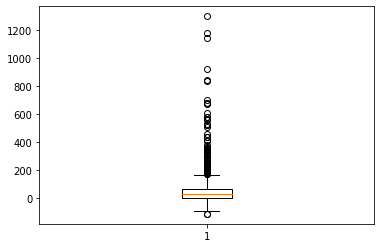

In [119]:
# Boxplot for Avg Payment Days
plt.boxplot(cust_seg['AVG_PAY_DAYS'])
plt.show()

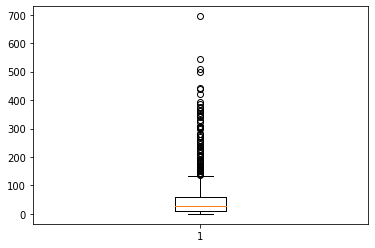

In [120]:
# Boxplot for STD Deviation
plt.boxplot(cust_seg['STD_PAY_DAYS'])
plt.show()

In [121]:
# Creating the Cluster DF
cluster_df = cust_seg.copy()
cluster_df.reset_index(inplace=True)
cluster_df.drop('CUSTOMER_NAME',axis=1,inplace=True)
cluster_df.head()

,AVG_PAY_DAYS,STD_PAY_DAYS
0,-8.681529,17.803787
1,-42.666667,11.183321
2,28.000000,65.053824
3,-74.000000,0.000000
4,3.473118,40.854678


### Clustering process

In [122]:
# Importing the libraries needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_df_scaled = scaler.fit_transform(cluster_df)
cluster_df_scaled.shape

(689, 2)

In [123]:
# Making the DF for the cluster data set
cluster_df_scaleds = pd.DataFrame(cluster_df_scaled)
cluster_df_scaleds.head()

,0,1
0,-0.501758,-0.453592
1,-0.737405,-0.530766
2,-0.247416,0.097198
3,-0.954664,-0.661129
4,-0.417480,-0.184889


In [124]:
# Performing the clustering process
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

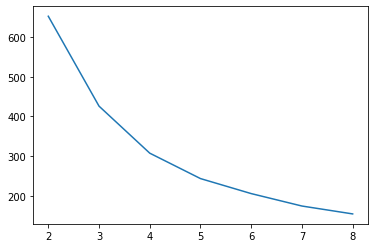

In [125]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters = num_cluster,max_iter=50)
    kmeans.fit(cluster_df_scaleds)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
plt.xticks(ticks=(0,1,2,3,4,5,6), labels=range_n_clusters)
plt.show()

In [ ]:
# We can see there is a substantial drop in value from 2 to 3, therefore we can choose 3

In [128]:
# Checking the Silhouette Score 

range_n_clusters = [2,3,4,5,6,7,8]
for num_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters = num_cluster,max_iter=50)
    kmeans.fit(cluster_df_scaleds)
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(cluster_df_scaleds,cluster_labels)
    print('For n_cluster={0}, the silhouette scor is {1}'.format(num_cluster,silhouette_avg))
    


For n_cluster=2, the silhouette scor is 0.757127769694936
For n_cluster=3, the silhouette scor is 0.7480532464904536
For n_cluster=4, the silhouette scor is 0.6186661272191294
For n_cluster=5, the silhouette scor is 0.6192170932888836
For n_cluster=6, the silhouette scor is 0.43277397484637753
For n_cluster=7, the silhouette scor is 0.4290681465837504
For n_cluster=8, the silhouette scor is 0.44611192237606784


In [129]:
# Above score and the elbow curve show that optimal cluster number should be 3
kmeans=KMeans(n_clusters=3,max_iter=50,random_state=42)
kmeans.fit(cluster_df_scaleds)

KMeans(max_iter=50, n_clusters=3, random_state=42)

In [130]:
# Cluster ID
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [131]:
# Adding the cluster id into the DF
cust_seg['CLUSTER_ID'] = kmeans.labels_

In [132]:
cust_seg.head()

,AVG_PAY_DAYS,STD_PAY_DAYS,CLUSTER_ID
CUSTOMER_NAME,,,
3D D Corp,-8.681529,17.803787,1
6TH Corp,-42.666667,11.183321,1
A3 D Corp,28.000000,65.053824,1
ABC Corp,-74.000000,0.000000,1
ABDU Corp,3.473118,40.854678,1


In [134]:
# Count of Cx in each of the clusters
cust_seg.groupby('CLUSTER_ID')['CLUSTER_ID'].count()

CLUSTER_ID
0     19
1    611
2     59
Name: CLUSTER_ID, dtype: int64

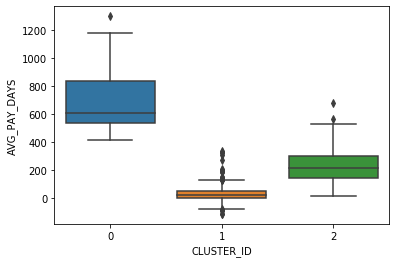

In [135]:
# Box plot of the cluster
sns.boxplot(data=cust_seg,x='CLUSTER_ID',y='AVG_PAY_DAYS')
plt.show()

In [ ]:
# CX in the cluster 0 take most time to complete the payments more than a year

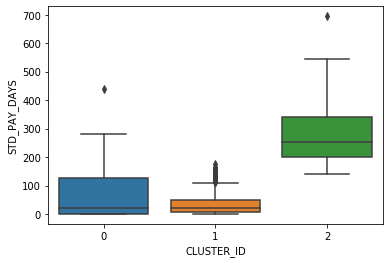

In [136]:
# Box plot of the cluster STD
sns.boxplot(data=cust_seg,x='CLUSTER_ID',y='STD_PAY_DAYS')
plt.show()

Cluster 0 has major delay with moderate SD
Cluster 1 has early payments with small SD
Cluster 2 has small delays but a bit high SD

In [137]:
# Making the Cust dict
cust_dict = cust_seg.copy()
cust_dict.drop(['AVG_PAY_DAYS','STD_PAY_DAYS'],axis=1,inplace=True)
cust_dict.head()

,CLUSTER_ID
CUSTOMER_NAME,
3D D Corp,1
6TH Corp,1
A3 D Corp,1
ABC Corp,1
ABDU Corp,1


In [139]:
cust_dict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 3D D Corp to ZV F Corp
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CLUSTER_ID  689 non-null    int32
dtypes: int32(1)
memory usage: 28.1+ KB


In [140]:
# Merging the cust_dict with the original DF
merged_df = pd.merge(rec_pay_data,cust_dict,how='inner',on='CUSTOMER_NAME')
merged_df.shape

(42058, 19)

In [141]:
merged_df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,RECEIPT_DATE,CURRENCY_CODE,USD Amount,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,TARGET,PAYMENT_IN_DAYS,INVOICE_MONTH,INVOICE_YEAR,DUE_MONTH,DUE_DAY,INVOICE_DAY,CLUSTER_ID
0,WIRE,C EA Corp,2021-04-20,USD,101018.630400,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,1,111,11,2020,12,2,0,1
1,WIRE,C EA Corp,2021-05-19,AED,2859.090000,2021-04-07,2021-05-30,30 Days from EOM,INV,AED,Non Goods,0,-11,4,2021,5,6,2,1
2,WIRE,C EA Corp,2021-02-20,AED,10.578625,2020-11-26,2020-12-26,30 Days from Inv Date,INV,AED,Non Goods,1,56,11,2020,12,5,3,1
3,WIRE,RADW Corp,2021-01-31,SAR,48990.211330,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,1,3,12,2020,1,3,1,1
4,WIRE,RADW Corp,2021-01-31,SAR,41991.609710,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,0,-29,1,2021,3,0,5,1


## 5.Data Prep for Model

In [142]:
merged_df.columns

Index(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'CURRENCY_CODE',
       'USD Amount', 'INVOICE_CREATION_DATE', 'DUE_DATE', 'PAYMENT_TERM',
       'INVOICE_CLASS', 'INVOICE_CURRENCY_CODE', 'INVOICE_TYPE', 'TARGET',
       'PAYMENT_IN_DAYS', 'INVOICE_MONTH', 'INVOICE_YEAR', 'DUE_MONTH',
       'DUE_DAY', 'INVOICE_DAY', 'CLUSTER_ID'],
      dtype='object')

In [144]:
# As we have to test the model on open invoice so we can check the columns in the open invoice data set
op_inv_data.columns

Index(['AS_OF_DATE', 'Customer Type', 'Customer_Name', 'Customer Account No',
       'Transaction Number', 'Transaction Date', 'Payment Term', 'Due Date',
       'Transaction Currency', 'Local Amount', 'Transaction Class', 'AGE',
       'USD Amount', 'INV_CREATION_DATE'],
      dtype='object')

In [146]:
# Dropping the columns that are not used
merged_df.drop(['RECEIPT_METHOD', 'CUSTOMER_NAME', 'RECEIPT_DATE', 'CURRENCY_CODE','INVOICE_CREATION_DATE',
               'DUE_DATE','INVOICE_TYPE','PAYMENT_IN_DAYS','INVOICE_MONTH', 'INVOICE_YEAR', 'INVOICE_DAY'],
              axis=1, inplace=True)
merged_df.shape

(42058, 8)

In [147]:
# Let us check the unique records to have an idea of the dummy variable
merged_df.nunique()

USD Amount               7819
PAYMENT_TERM               12
INVOICE_CLASS               3
INVOICE_CURRENCY_CODE      10
TARGET                      2
DUE_MONTH                  12
DUE_DAY                     7
CLUSTER_ID                  3
dtype: int64

### Dummy Variable

In [148]:
merged_df.head()

,USD Amount,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,TARGET,DUE_MONTH,DUE_DAY,CLUSTER_ID
0,101018.630400,30 Days from EOM,INV,AED,1,12,2,1
1,2859.090000,30 Days from EOM,INV,AED,0,5,6,1
2,10.578625,30 Days from Inv Date,INV,AED,1,12,5,1
3,48990.211330,30 Days from Inv Date,INV,SAR,1,1,3,1
4,41991.609710,30 Days from Inv Date,INV,SAR,0,3,0,1


In [149]:
# Creating Dummy Variable for the cat variables
dummy1 = pd.get_dummies(merged_df[['PAYMENT_TERM','INVOICE_CLASS','INVOICE_CURRENCY_CODE']],drop_first=True)

In [150]:
# Merging the Dummy variables with the DF
merged_df = pd.concat([merged_df,dummy1],axis=1)
merged_df.shape

(42058, 30)

In [151]:
merged_df.head()

,USD Amount,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,TARGET,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,101018.630400,30 Days from EOM,INV,AED,1,12,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2859.090000,30 Days from EOM,INV,AED,0,5,6,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,10.578625,30 Days from Inv Date,INV,AED,1,12,5,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,48990.211330,30 Days from Inv Date,INV,SAR,1,1,3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,41991.609710,30 Days from Inv Date,INV,SAR,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [152]:
# Dropping the cat columns for which the dummy was created
merged_df.drop(['PAYMENT_TERM','INVOICE_CLASS','INVOICE_CURRENCY_CODE'],axis=1,inplace=True)
merged_df.shape

(42058, 27)

In [153]:
merged_df.head()

,USD Amount,TARGET,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,101018.630400,1,12,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2859.090000,0,5,6,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,10.578625,1,12,5,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,48990.211330,1,1,3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,41991.609710,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [154]:
# Creation of Dummy variables for the remaining columns
# Due_month
dummy2 = pd.get_dummies(merged_df['DUE_MONTH'],prefix='DUE_MONTH',drop_first=True)
dummy2.head()

,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [156]:
merged_df = pd.concat([merged_df,dummy2],axis=1)
merged_df.shape

(42058, 38)

In [157]:
# Dummy for DUE_DAY
dummy3 = pd.get_dummies(merged_df['DUE_DAY'],prefix='DUE_DAY',drop_first=True)
dummy3.head()

,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6
0,0,1,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0


In [158]:
# concating 
merged_df = pd.concat([merged_df,dummy3],axis=1)
merged_df.shape

(42058, 44)

In [159]:
dummy4 = pd.get_dummies(merged_df['CLUSTER_ID'],prefix='CLUSTER_ID',drop_first=True)
dummy4.head()

,CLUSTER_ID_1,CLUSTER_ID_2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [160]:
merged_df = pd.concat([merged_df,dummy4],axis=1)
merged_df.shape

(42058, 46)

In [161]:
# Dropping the columns for which dummies have been created
merged_df.head()

,USD Amount,TARGET,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,101018.630400,1,12,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,2859.090000,0,5,6,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,10.578625,1,12,5,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
3,48990.211330,1,1,3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,41991.609710,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [162]:
merged_df.drop(['DUE_MONTH','DUE_DAY','CLUSTER_ID'],axis=1, inplace=True)
merged_df.shape

(42058, 43)

### Checking for Data Imbalance

In [163]:
# As already checked there is no major data imbalace so we will proceed as it is

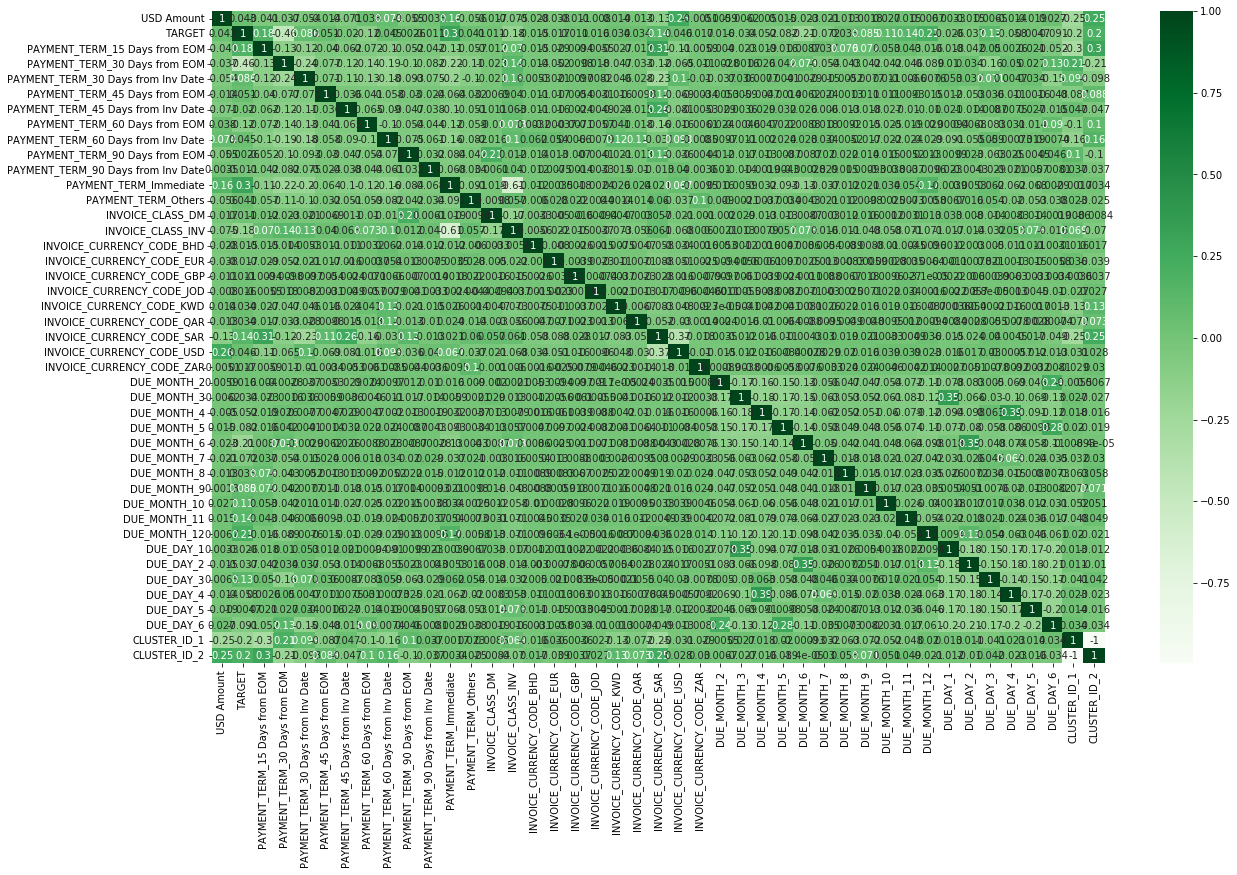

In [166]:
plt.figure(figsize=(20,12))
sns.heatmap(merged_df.corr(),cmap='Greens',annot=True)
plt.show()

## 6. Model Building

### LR Model and Evaluation

#### Train Test Split

In [167]:
X = merged_df.drop('TARGET',axis=1)
y = merged_df['TARGET']
X.shape,y.shape

((42058, 42), (42058,))

In [168]:
from sklearn.model_selection import train_test_split

In [169]:
# making the train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=42,stratify=y)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((29440, 42), (12618, 42), (29440,), (12618,))

In [170]:
y_train.value_counts(normalize=True)

1    0.639096
0    0.360904
Name: TARGET, dtype: float64

In [171]:
# Scaling the data in the DF
from sklearn.preprocessing import MinMaxScaler

In [172]:
scaler= MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [174]:
# Converting to data frame
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

,USD Amount,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,0.028754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000614,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.014069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000655,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.103657,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [175]:
# Converting the test data also to the DF
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled.head()

,USD Amount,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,0.004923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000123,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.024624,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.003531,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.210528,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### LR Model Building 

In [176]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [177]:
logreg = LogisticRegression(random_state=42, max_iter=200)


In [178]:
# Fitting of train data
rfecv=RFECV(estimator=logreg,cv=5,n_jobs=-1)
rfecv.fit(X_train_scaled,y_train)

RFECV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=42),
      n_jobs=-1)

In [179]:
# Checking the scores of cross validation 
rfecv.grid_scores_

array([[0.63909647, 0.63909647, 0.63909647, 0.63909647, 0.63909647],
       [0.63909647, 0.63909647, 0.63909647, 0.63909647, 0.63909647],
       [0.63909647, 0.63909647, 0.63909647, 0.63909647, 0.63909647],
       [0.63909647, 0.63909647, 0.63909647, 0.63909647, 0.63909647],
       [0.6484375 , 0.64741848, 0.63909647, 0.63909647, 0.63909647],
       [0.65777853, 0.65455163, 0.64690897, 0.65574049, 0.64877717],
       [0.77887228, 0.77190897, 0.77173913, 0.77072011, 0.77513587],
       [0.78549592, 0.78192935, 0.77734375, 0.77072011, 0.78311821],
       [0.796875  , 0.79772418, 0.79466712, 0.77819293, 0.79619565],
       [0.796875  , 0.80417799, 0.79976223, 0.78974185, 0.79619565],
       [0.796875  , 0.80672554, 0.80638587, 0.79076087, 0.79619565],
       [0.80519701, 0.80672554, 0.80655571, 0.79602582, 0.80621603],
       [0.80519701, 0.80672554, 0.80655571, 0.79602582, 0.80621603],
       [0.80587636, 0.80672554, 0.80655571, 0.79500679, 0.80638587],
       [0.80587636, 0.79806386, 0.

In [180]:
# Number of features
num_features=X_train_scaled.shape[1]
num_features

42

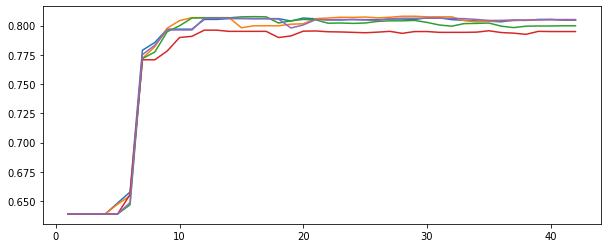

In [181]:
# plotting the results
plt.figure(figsize=(10,4))
plt.plot(range(1,num_features+1),rfecv.grid_scores_)
plt.show()

In [182]:
# Let us find the best number of features
rfecv.n_features_

12

In [183]:
# Check the boolean value of variables selected.
rfecv.support_

array([False,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True])

In [184]:
# The rank of the variables 
rfecv.ranking_

array([11,  1,  1, 24, 31, 12,  1, 18, 14, 13,  1, 23,  6,  5, 10,  4, 29,
        2, 16, 21, 20, 22,  3, 15,  7,  9,  8,  1,  1, 19,  1,  1,  1,  1,
       27, 17, 30, 25, 26, 28,  1,  1])

In [185]:
# Let us check the variables considered by the model.
cols_to_keep=X_train_scaled.columns[rfecv.support_]
cols_to_keep

Index(['PAYMENT_TERM_15 Days from EOM', 'PAYMENT_TERM_30 Days from EOM',
       'PAYMENT_TERM_60 Days from EOM', 'PAYMENT_TERM_Immediate',
       'DUE_MONTH_6', 'DUE_MONTH_7', 'DUE_MONTH_9', 'DUE_MONTH_10',
       'DUE_MONTH_11', 'DUE_MONTH_12', 'CLUSTER_ID_1', 'CLUSTER_ID_2'],
      dtype='object')

### First Model

In [186]:
# importing RFE from scikit learn
from sklearn.feature_selection import RFE

In [187]:

rfe1=RFE(estimator=logreg,n_features_to_select=12)
rfe1.fit(X_train_scaled,y_train)

RFE(estimator=LogisticRegression(max_iter=200, random_state=42),
    n_features_to_select=12)

In [188]:
# Finding the columns in rfe1
cols_to_keep=X_train_scaled.columns[rfe1.support_]
cols_to_keep

Index(['PAYMENT_TERM_15 Days from EOM', 'PAYMENT_TERM_30 Days from EOM',
       'PAYMENT_TERM_60 Days from EOM', 'PAYMENT_TERM_Immediate',
       'DUE_MONTH_6', 'DUE_MONTH_7', 'DUE_MONTH_9', 'DUE_MONTH_10',
       'DUE_MONTH_11', 'DUE_MONTH_12', 'CLUSTER_ID_1', 'CLUSTER_ID_2'],
      dtype='object')

In [189]:
# Keeping the required columns in X_train and X_test
X_train=X_train_scaled[cols_to_keep]
X_test=X_test_scaled[cols_to_keep]
X_train.shape,X_test.shape

((29440, 12), (12618, 12))

In [190]:
import statsmodels.api as sm

In [191]:
X_train_sm=sm.add_constant(X_train,has_constant="add")
X_test_sm=sm.add_constant(X_test,has_constant="add")

In [192]:
# first model
model1=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
result1=model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                29440
Model:                            GLM   Df Residuals:                    29427
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 05 Mar 2024   Deviance:                          nan
Time:                        18:51:06   Pearson chi2:                 2.57e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            32.4242   8.65e+05   3.75e-05      1.000    -1.7e+06     1.7e+06
PAYMENT_TERM_15 Days from EOM     2.1388      0.126     16.908      0.000       1.891       2.387
PAYMENT_TERM_30 Days from EOM    -2.3233      0.042    -55.274      0.000      -2.406      -2.241
PAYMENT_TERM_60 Days from EOM    -1.3395      0.053    -25.052      0.000      -1.444      -1.235
PAYMENT_TERM_Immediate            2.8409      0.113     25.225      0.000       2.620       3.062
DUE_MONTH_6                      -1.1742      0.048    -24.238      0.000      -1.269      -1.079
DUE_MONTH_7                      -1.5209      0.097    -15.660      0.000      -1.711      -1.331
DUE_MONTH_9                       3.0903      0.349      8.845      0.000       2.406       3.775
DUE_MONTH_10                      5.8314      1.005      5.805      0.000       3.863       7.800
DUE_MONTH_11                     38.5175   2.14e+06    1.8e-05      1.000   -4.19e+06    4.19e+06
DUE_MONTH_12                     38.4899   1.41e+06   2.73e-05      1.000   -2.76e+06    2.76e+06
CLUSTER_ID_1                    -31.7901   8.65e+05  -3.67e-05      1.000    -1.7e+06     1.7e+06
CLUSTER_ID_2                    -31.1268   8.65e+05   -3.6e-05      1.000    -1.7e+06     1.7e+06
=================================================================================================
"""

In [193]:
# Dropping the variables which have p-value more than 0.05, one-by-one
# Dropping the variable "DUE_MONTH_11" from train and test dataset
X_train_sm=X_train_sm.drop("DUE_MONTH_11",axis=1)
X_test_sm=X_test_sm.drop("DUE_MONTH_11",axis=1)
X_train_sm.shape,X_test_sm.shape

((29440, 12), (12618, 12))

### Second Model

In [194]:
model2=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
result2=model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                29440
Model:                            GLM   Df Residuals:                    29428
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 05 Mar 2024   Deviance:                          nan
Time:                        22:44:51   Pearson chi2:                 2.66e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           118.5073   8.89e+06   1.33e-05      1.000   -1.74e+07    1.74e+07
PAYMENT_TERM_15 Days from EOM     2.1612      0.126     17.117      0.000       1.914       2.409
PAYMENT_TERM_30 Days from EOM    -2.2629      0.040    -55.925      0.000      -2.342      -2.184
PAYMENT_TERM_60 Days from EOM    -1.3345      0.053    -25.334      0.000      -1.438      -1.231
PAYMENT_TERM_Immediate            2.8553      0.112     25.385      0.000       2.635       3.076
DUE_MONTH_6                      -1.2418      0.048    -25.713      0.000      -1.336      -1.147
DUE_MONTH_7                      -1.5845      0.097    -16.311      0.000      -1.775      -1.394
DUE_MONTH_9                       3.0029      0.349      8.611      0.000       2.319       3.686
DUE_MONTH_10                      5.7364      1.004      5.712      0.000       3.768       7.705
DUE_MONTH_12                     38.2851   1.41e+06   2.72e-05      1.000   -2.76e+06    2.76e+06
CLUSTER_ID_1                   -117.8150   8.89e+06  -1.33e-05      1.000   -1.74e+07    1.74e+07
CLUSTER_ID_2                   -117.1472   8.89e+06  -1.32e-05      1.000   -1.74e+07    1.74e+07
=================================================================================================
"""

In [195]:
# Dropping the variables which have p-value more than 0.05, one-by-one
# Dropping the variable "DUE_MONTH_12" from train and test dataset
X_train_sm=X_train_sm.drop("DUE_MONTH_12",axis=1)
X_test_sm=X_test_sm.drop("DUE_MONTH_12",axis=1)
X_train_sm.shape,X_test_sm.shape

((29440, 11), (12618, 11))

### Third Model

In [196]:
model3=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
result3=model3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                29440
Model:                            GLM   Df Residuals:                    29429
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13280.
Date:                Tue, 05 Mar 2024   Deviance:                       26560.
Time:                        22:52:40   Pearson chi2:                 2.88e+04
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            24.4499   1.57e+04      0.002      0.999   -3.07e+04    3.08e+04
PAYMENT_TERM_15 Days from EOM     2.1572      0.126     17.090      0.000       1.910       2.405
PAYMENT_TERM_30 Days from EOM    -2.2158      0.038    -57.790      0.000      -2.291      -2.141
PAYMENT_TERM_60 Days from EOM    -1.3053      0.051    -25.632      0.000      -1.405      -1.205
PAYMENT_TERM_Immediate            2.9571      0.112     26.374      0.000       2.737       3.177
DUE_MONTH_6                      -1.3711      0.048    -28.543      0.000      -1.465      -1.277
DUE_MONTH_7                      -1.7087      0.097    -17.618      0.000      -1.899      -1.519
DUE_MONTH_9                       2.8592      0.348      8.212      0.000       2.177       3.542
DUE_MONTH_10                      5.5826      1.004      5.560      0.000       3.614       7.551
CLUSTER_ID_1                    -23.6229   1.57e+04     -0.002      0.999   -3.08e+04    3.07e+04
CLUSTER_ID_2                    -22.9870   1.57e+04     -0.001      0.999   -3.08e+04    3.07e+04
=================================================================================================
"""

In [197]:
# Dropping the variables which have p-value more than 0.05, one-by-one
# Dropping the variable "CLUSTER_ID_1" from train and test dataset
X_train_sm=X_train_sm.drop("CLUSTER_ID_1",axis=1)
X_test_sm=X_test_sm.drop("CLUSTER_ID_1",axis=1)
X_train_sm.shape,X_test_sm.shape

((29440, 10), (12618, 10))

### Fourth Model 

In [198]:
model4=sm.GLM(np.array(y_train),X_train_sm,family=sm.families.Binomial())
result4=model4.fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                29440
Model:                            GLM   Df Residuals:                    29430
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13299.
Date:                Tue, 05 Mar 2024   Deviance:                       26598.
Time:                        22:56:41   Pearson chi2:                 2.89e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.8321      0.022     37.401      0.000       0.788       0.876
PAYMENT_TERM_15 Days from EOM     2.1928      0.126     17.371      0.000       1.945       2.440
PAYMENT_TERM_30 Days from EOM    -2.2189      0.038    -57.902      0.000      -2.294      -2.144
PAYMENT_TERM_60 Days from EOM    -1.3068      0.051    -25.675      0.000      -1.407      -1.207
PAYMENT_TERM_Immediate            2.9537      0.112     26.344      0.000       2.734       3.173
DUE_MONTH_6                      -1.3653      0.048    -28.488      0.000      -1.459      -1.271
DUE_MONTH_7                      -1.7054      0.097    -17.627      0.000      -1.895      -1.516
DUE_MONTH_9                       2.8743      0.348      8.261      0.000       2.192       3.556
DUE_MONTH_10                      5.5862      1.004      5.563      0.000       3.618       7.554
CLUSTER_ID_2                      0.6292      0.034     18.645      0.000       0.563       0.695
=================================================================================================
"""

In [199]:
# check the VIF's for the same as all values are less than 0.05
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data=pd.DataFrame()
vif_data["Features"]=X_train_sm.columns
vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) for i in range(len(X_train_sm.columns))]
vif_data

,Features,VIF
0,const,2.787946
1,PAYMENT_TERM_15 Days from EOM,1.154744
2,PAYMENT_TERM_30 Days from EOM,1.153192
3,PAYMENT_TERM_60 Days from EOM,1.073112
4,PAYMENT_TERM_Immediate,1.121179
5,DUE_MONTH_6,1.024676
6,DUE_MONTH_7,1.010495
7,DUE_MONTH_9,1.011407
8,DUE_MONTH_10,1.011082
9,CLUSTER_ID_2,1.154136


In [200]:
# Building the model with 9 features using sklearn and check the cross_val_score
rfe9=RFE(estimator=logreg,n_features_to_select=9)
rfe9.fit(X_train_scaled,y_train)

RFE(estimator=LogisticRegression(max_iter=200, random_state=42),
    n_features_to_select=9)

#### Let us use the cross val score to understand how the model will perform on the test data

In [201]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score

In [202]:
# Accuracy using cross val score
cross_val_score(rfe9,X_train,y_train,cv=5,n_jobs=-1).mean()

0.7950407608695652

In [203]:
# recall using cross val score
cross_val_score(rfe9,X_train,y_train,cv=5,n_jobs=-1,scoring="recall").mean()

0.9090087695987246

In [204]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score

In [205]:
# Predictions on the training set
y_train_pred_lr=result4.predict(X_train_sm)
y_train_pred_lr.shape

(29440,)

In [206]:
# Creating a dataframe with the Actual Class, Predicted Probability and Predicted Class on training set 
train_lr=pd.DataFrame()
train_lr["Predicted_Prob"]=y_train_pred_lr
train_lr["Actual_Class"]=y_train.values
train_lr["Predicted_Class"]=np.where(train_lr["Predicted_Prob"]>0.5,1,0)
train_lr.head()

,Predicted_Prob,Actual_Class,Predicted_Class
0,0.696792,0,1
1,0.199922,0,0
2,0.811719,1,1
3,0.696792,1,1
4,0.538530,0,1


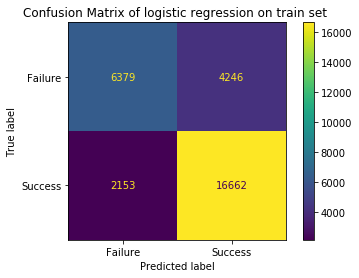

In [207]:
# confusion matrix of train set
confusion_matrix=metrics.confusion_matrix(train_lr["Actual_Class"],train_lr["Predicted_Class"])
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Failure","Success"])
cm_display.plot()
plt.title("Confusion Matrix of logistic regression on train set ")
plt.show()

In [208]:
# Let us check the accuracy on the train set
metrics.accuracy_score(train_lr["Actual_Class"],train_lr["Predicted_Class"])

0.7826426630434783

In [209]:
print(metrics.classification_report(train_lr["Actual_Class"],train_lr["Predicted_Class"]))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67     10625
           1       0.80      0.89      0.84     18815

    accuracy                           0.78     29440
   macro avg       0.77      0.74      0.75     29440
weighted avg       0.78      0.78      0.78     29440



#### The above values look good, so we can proceed with the ROC curve

In [210]:
# Creating function for ROC plot
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [211]:
fpr, tpr, thresholds = metrics.roc_curve(train_lr["Actual_Class"], train_lr["Predicted_Prob"], drop_intermediate = False )

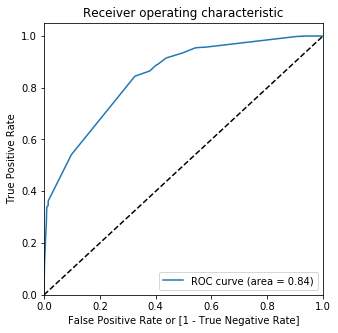

In [212]:
# ROC curve shows that this is a decent model
draw_roc(train_lr.Actual_Class, train_lr["Predicted_Prob"])

### Finding the optmal cutoff point

In [213]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    train_lr[i]= train_lr["Predicted_Prob"].map(lambda x: 1 if x > i else 0)
train_lr.head()

,Predicted_Prob,Actual_Class,Predicted_Class,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.696792,0,1,1,1,1,1,1,1,1,0,0,0
1,0.199922,0,0,1,1,0,0,0,0,0,0,0,0
2,0.811719,1,1,1,1,1,1,1,1,1,1,1,0
3,0.696792,1,1,1,1,1,1,1,1,1,0,0,0
4,0.538530,0,1,1,1,1,1,1,1,0,0,0,0


In [214]:
# Now let's calculate accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(train_lr["Actual_Class"], train_lr[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.639096  1.000000  0.000000
0.1   0.1  0.665251  0.998724  0.074729
0.2   0.2  0.764164  0.956365  0.423812
0.3   0.3  0.774932  0.954026  0.457788
0.4   0.4  0.782779  0.889822  0.593224
0.5   0.5  0.782643  0.885570  0.600376
0.6   0.6  0.783084  0.844379  0.674541
0.7   0.7  0.671909  0.542280  0.901459
0.8   0.8  0.671807  0.541855  0.901929
0.9   0.9  0.583628  0.356843  0.985224


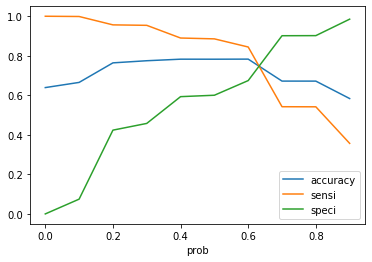

In [215]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### The optimal cut off point suggested by the above plot is around 0.62. However we can see that sensitivity drops from 0.885 to 0.844 when we change the probability threshold from 0.5 to 0.6. Hence we will stick to 0.5 probability as the threshold for prediction

## 7.Model Building- Random Forest, Hyper Parameter Tuning and Evaluation

#### We will use the GridSearch CV to find the combination of parameters that give us a model that can perform well and then build the model

In [216]:
# import the required methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [217]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1,oob_score=True)

In [218]:
hyper_params = {'max_depth': [5, 10, 15, 20],
                'max_features': [5, 10, 15, 20],
                'min_samples_leaf': [200, 500, 1000, 1500],
                'n_estimators': [25, 50, 80, 100]
               }

In [219]:
rf_cv=GridSearchCV(estimator=rf, 
             param_grid=hyper_params,
             verbose=1,
             cv=5,
             n_jobs=-1)

In [220]:
# let us see the shape of data which is to be used
X_train_scaled.shape,X_test_scaled.shape

((29440, 42), (12618, 42))

In [221]:
# fitting on the train data
rf_cv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [5, 10, 15, 20],
                         'min_samples_leaf': [200, 500, 1000, 1500],
                         'n_estimators': [25, 50, 80, 100]},
             verbose=1)

In [222]:
# finding the best random forest
rf_best=rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [223]:
# The score of the best random forest
rf_cv.best_score_

0.7979619565217393

In [224]:
cv_df=pd.DataFrame(rf_cv.cv_results_)
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.861115,0.013522,0.114545,0.003216,5,5,200,25,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.791780,0.783288,0.778702,0.778533,0.784647,0.783390,0.004849,89
1,1.022298,0.045552,0.122918,0.009107,5,5,200,50,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.788383,0.773947,0.774287,0.773607,0.777853,0.777615,0.005596,105
2,1.332608,0.035913,0.145274,0.023197,5,5,200,80,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.789062,0.778023,0.778363,0.775306,0.779891,0.780129,0.004705,94
3,1.842746,0.211112,0.111126,0.003065,5,5,200,100,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.786855,0.774287,0.775306,0.777683,0.778023,0.778431,0.004441,98
4,0.553134,0.144852,0.128243,0.016696,5,5,500,25,"{'max_depth': 5, 'max_features': 5, 'min_sampl...",0.783967,0.769871,0.773098,0.766304,0.774457,0.773539,0.005926,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2.702728,0.260333,0.117753,0.007998,20,20,1000,100,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.769192,0.760360,0.759171,0.758662,0.763417,0.762160,0.003884,182
252,0.612046,0.075782,0.154675,0.072287,20,20,1500,25,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.766814,0.760360,0.758492,0.757473,0.762058,0.761039,0.003288,205
253,1.047679,0.076651,0.193042,0.063298,20,20,1500,50,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.766814,0.760360,0.758492,0.757473,0.762058,0.761039,0.003288,205
254,2.260393,0.146550,0.132981,0.020372,20,20,1500,80,"{'max_depth': 20, 'max_features': 20, 'min_sam...",0.766814,0.760360,0.758492,0.757473,0.762058,0.761039,0.003288,205


In [225]:
# sorting the values in cv_df
cv_df.sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
83,2.354322,0.259104,0.111327,0.001435,10,10,200,100,"{'max_depth': 10, 'max_features': 10, 'min_sam...",0.799932,0.795686,0.800781,0.792799,0.800611,0.797962,0.003184,1
147,2.734873,0.362337,0.134192,0.017457,15,10,200,100,"{'max_depth': 15, 'max_features': 10, 'min_sam...",0.798913,0.794837,0.799932,0.792120,0.801800,0.797520,0.003534,2
211,2.484925,0.213389,0.145178,0.024483,20,10,200,100,"{'max_depth': 20, 'max_features': 10, 'min_sam...",0.799253,0.793988,0.800442,0.791780,0.801970,0.797486,0.003918,3
82,2.246095,0.063961,0.128328,0.019187,10,10,200,80,"{'max_depth': 10, 'max_features': 10, 'min_sam...",0.799762,0.793988,0.800102,0.793478,0.799592,0.797385,0.002990,4
146,2.634568,0.072220,0.124146,0.016091,15,10,200,80,"{'max_depth': 15, 'max_features': 10, 'min_sam...",0.797724,0.794158,0.800951,0.791610,0.801461,0.797181,0.003821,5


#### Building the random forest model

In [226]:
rf_best.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=200,
                       n_jobs=-1, oob_score=True, random_state=42)

In [227]:
# cross val score of best_rf
cross_val_score(rf_best,X_train_scaled,y_train,cv=5,n_jobs=-1).mean()

0.7979619565217393

In [228]:
rf_best.oob_score_

0.7984035326086957

In [229]:
# The oob_score is almost the same as cross val score which means model is not overfitting.

In [230]:
# recall score of best_rf
cross_val_score(rf_best,X_train_scaled,y_train,cv=5,n_jobs=-1,scoring="recall").mean()

0.9187882009035343

In [231]:
from sklearn.metrics import plot_roc_curve

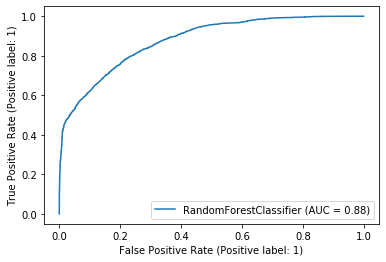

In [232]:
plot_roc_curve(rf_best,X_train_scaled,y_train)

In [233]:
# Plotting the variable wise feature importance given by random forest
imp_df=pd.DataFrame({"VarName":X_train_scaled.columns,"Imp":rf_best.feature_importances_})
imp_df.sort_values(by="Imp",ascending=False)

,VarName,Imp
2,PAYMENT_TERM_30 Days from EOM,0.412979
10,PAYMENT_TERM_Immediate,0.152829
33,DUE_MONTH_12,0.068208
27,DUE_MONTH_6,0.060389
6,PAYMENT_TERM_60 Days from EOM,0.048591
40,CLUSTER_ID_1,0.045829
1,PAYMENT_TERM_15 Days from EOM,0.032649
41,CLUSTER_ID_2,0.031238
0,USD Amount,0.028567
3,PAYMENT_TERM_30 Days from Inv Date,0.019036


In [234]:
# Predictions on the train set using rf_best
y_train_pred_rf=rf_best.predict(X_train_scaled)
y_train_pred_rf

array([1, 0, 1, ..., 0, 1, 1])

In [235]:
train_rf=pd.DataFrame()
train_rf["Predicted_Class"]=y_train_pred_rf
train_rf["Actual_Class"]=y_train.values
train_rf.head()

,Predicted_Class,Actual_Class
0,1,0
1,0,0
2,1,1
3,1,1
4,0,0


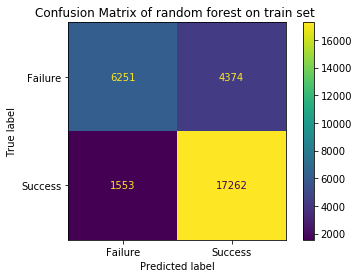

In [236]:
# confusion matrix of rf_best on train set
confusion_matrix=metrics.confusion_matrix(train_rf["Actual_Class"],train_rf["Predicted_Class"])
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Failure","Success"])
cm_display.plot()
plt.title("Confusion Matrix of random forest on train set ")
plt.show()

In [237]:
# The accuracy score on rf_best
metrics.accuracy_score(train_rf["Actual_Class"],train_rf["Predicted_Class"])

0.7986752717391304

In [238]:
print(metrics.classification_report(train_rf["Actual_Class"],train_rf["Predicted_Class"]))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68     10625
           1       0.80      0.92      0.85     18815

    accuracy                           0.80     29440
   macro avg       0.80      0.75      0.77     29440
weighted avg       0.80      0.80      0.79     29440



- Random Forest rf_best gives an accuracy of 80%. Also it has a very good recall/sensitivity score of 92% on the train set. The auc in the roc curve is at 0.88.

- Checck the performance of logistic regression model- model 4 and random forest - rf_best perform on the test set

### Making Prediction on the test set

In [239]:
# Probability Predictions on the test set using model6
y_test_pred_lr=result4.predict(X_test_sm)
y_test_pred_lr.shape

(12618,)

In [240]:
test_lr=pd.DataFrame()
test_lr["Predicted_Prob"]=y_test_pred_lr
test_lr["Actual_Class"]=y_test.values
test_lr["Predicted_Class"]=np.where(test_lr["Predicted_Prob"]>0.5,1,0)
test_lr.head()

,Predicted_Prob,Actual_Class,Predicted_Class
0,0.977811,1,1
1,0.696792,1,1
2,0.199922,0,0
3,0.369768,1,0
4,0.811719,0,1


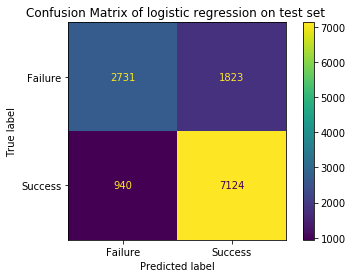

In [241]:
# Confusion matrix on test data with model4
confusion_matrix=metrics.confusion_matrix(test_lr["Actual_Class"],test_lr["Predicted_Class"])
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Failure","Success"])
cm_display.plot()
plt.title("Confusion Matrix of logistic regression on test set ")
plt.show()

In [242]:
# Accuracy
metrics.accuracy_score(test_lr["Actual_Class"],test_lr["Predicted_Class"])


0.7810271041369472

In [243]:
# Summary
print(metrics.classification_report(test_lr["Actual_Class"],test_lr["Predicted_Class"]))

              precision    recall  f1-score   support

           0       0.74      0.60      0.66      4554
           1       0.80      0.88      0.84      8064

    accuracy                           0.78     12618
   macro avg       0.77      0.74      0.75     12618
weighted avg       0.78      0.78      0.77     12618



#### Good performance on test set.Sensitivity/recall score is 88% and accuracy is 78% and is very close to the test score


##### We will make predictions on the test set using rf_best, cut off point of 0.38


In [244]:
y_test_pred_rf=rf_best.predict(X_test_scaled)
test_rf=pd.DataFrame()
test_rf["Predicted_Class"]=y_test_pred_rf
test_rf["Actual_Class"]=y_test.values
test_rf.head()

,Predicted_Class,Actual_Class
0,1,1
1,1,1
2,0,0
3,0,1
4,1,0


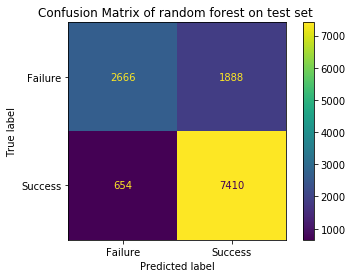

In [245]:
confusion_matrix=metrics.confusion_matrix(test_rf["Actual_Class"],test_rf["Predicted_Class"])
cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=["Failure","Success"])
cm_display.plot()
plt.title("Confusion Matrix of random forest on test set ")
plt.show()

In [246]:
metrics.accuracy_score(test_rf.Actual_Class,test_rf["Predicted_Class"])


0.7985417657314947

In [247]:
print(metrics.classification_report(test_rf["Actual_Class"],test_rf["Predicted_Class"]))


              precision    recall  f1-score   support

           0       0.80      0.59      0.68      4554
           1       0.80      0.92      0.85      8064

    accuracy                           0.80     12618
   macro avg       0.80      0.75      0.77     12618
weighted avg       0.80      0.80      0.79     12618



### Comparison  
    - log reg/model6
    Train Data:
        Accuracy           0.78
        Sensitivity/Recall 0.89
        Precision          0.8
        AUC                0.84
    Test Data:
        Accuracy           0.78
        Sensitivity/Recall 0.88
        Precision          0.8

    - random forest- rf_best
    Train Data:
        Accuracy           0.80
        Sensitivity/Recall 0.92
        Precision          0.80
        AUC                0.88
        oob_score          0.7987

    Test Data:
        Accuracy           0.8
        Sensitivity/Recall 0.92
        Precision          0.8

### Random forest is performing better, so we will consider this model

### 9. Apply the model on the open invoice data

In [248]:
### Checking the open invoice 

In [249]:
op_inv_data.shape

(88204, 14)

In [250]:
op_inv_data.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [251]:
op_inv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


In [252]:
# There are many columns which are not in the proper foramt,
# Date Columns, Transaction Number, local amount and USD Amount

In [253]:
op_inv_data.duplicated().sum()

0

In [254]:
# No duplicate records are present in the DF

In [255]:
# Null value check
op_inv_data.isnull().sum()

AS_OF_DATE              0
Customer Type           0
Customer_Name           0
Customer Account No     3
Transaction Number      9
Transaction Date        0
Payment Term            0
Due Date                0
Transaction Currency    0
Local Amount            0
Transaction Class       0
AGE                     0
USD Amount              0
INV_CREATION_DATE       0
dtype: int64

In [257]:
op_inv_data['AS_OF_DATE'].value_counts()

04-APR-2022 01:07:01    88204
Name: AS_OF_DATE, dtype: int64

In [259]:
# We can drop the "AS OF DATE", "Customer Account No","Transaction Number"
op_inv_data.drop(["AS_OF_DATE", "Customer Account No","Transaction Number"],axis=1,inplace=True)
op_inv_data.shape

(88204, 11)

In [261]:
#For our model deployment we need only negative values
# as they are the ones which are yet to become overdue
op_inv_data.describe()

,AGE
count,88204.000000
mean,183.430706
std,368.123334
min,-359.000000
25%,-17.000000
50%,47.000000
75%,242.000000
max,7343.000000


In [262]:
# Keeping the negative records only
op_inv_data=op_inv_data[op_inv_data["AGE"]<0]
op_inv_data.shape

(28080, 11)

In [263]:
op_inv_data.head()

,Customer Type,Customer_Name,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
2,Related Party,AL J Corp,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
4,Related Party,ALLI Corp,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30
5,Related Party,ALLI Corp,03/03/2022,30 Days from EOM,30/04/2022,AED,"1,264",INVOICE,-25,"1,264",3/3/2022 22:30
6,Related Party,ALLI Corp,15/03/2022,30 Days from EOM,30/04/2022,AED,"25,858",INVOICE,-25,"25,858",3/15/2022 19:06
7,Related Party,ALLI Corp,15/03/2022,30 Days from EOM,30/04/2022,AED,"39,873",INVOICE,-25,"39,873",3/15/2022 19:06


In [264]:
# Columns in rf_best.
# We need to work on open_inv_data to get the same.
X_train_scaled.columns

Index(['USD Amount', 'PAYMENT_TERM_15 Days from EOM',
       'PAYMENT_TERM_30 Days from EOM', 'PAYMENT_TERM_30 Days from Inv Date',
       'PAYMENT_TERM_45 Days from EOM', 'PAYMENT_TERM_45 Days from Inv Date',
       'PAYMENT_TERM_60 Days from EOM', 'PAYMENT_TERM_60 Days from Inv Date',
       'PAYMENT_TERM_90 Days from EOM', 'PAYMENT_TERM_90 Days from Inv Date',
       'PAYMENT_TERM_Immediate', 'PAYMENT_TERM_Others', 'INVOICE_CLASS_DM',
       'INVOICE_CLASS_INV', 'INVOICE_CURRENCY_CODE_BHD',
       'INVOICE_CURRENCY_CODE_EUR', 'INVOICE_CURRENCY_CODE_GBP',
       'INVOICE_CURRENCY_CODE_JOD', 'INVOICE_CURRENCY_CODE_KWD',
       'INVOICE_CURRENCY_CODE_QAR', 'INVOICE_CURRENCY_CODE_SAR',
       'INVOICE_CURRENCY_CODE_USD', 'INVOICE_CURRENCY_CODE_ZAR', 'DUE_MONTH_2',
       'DUE_MONTH_3', 'DUE_MONTH_4', 'DUE_MONTH_5', 'DUE_MONTH_6',
       'DUE_MONTH_7', 'DUE_MONTH_8', 'DUE_MONTH_9', 'DUE_MONTH_10',
       'DUE_MONTH_11', 'DUE_MONTH_12', 'DUE_DAY_1', 'DUE_DAY_2', 'DUE_DAY_3',
       'DUE_D

In [265]:
# Dropping the columns that are not required
op_inv_data.drop(["Customer Type","Transaction Date","Local Amount","INV_CREATION_DATE"],axis=1,inplace=True)
op_inv_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount
2,AL J Corp,30 Days from Inv Date,23/04/2022,USD,INVOICE,-18,"2,000"
4,ALLI Corp,30 Days from EOM,30/04/2022,AED,INVOICE,-25,"3,800"
5,ALLI Corp,30 Days from EOM,30/04/2022,AED,INVOICE,-25,"1,264"
6,ALLI Corp,30 Days from EOM,30/04/2022,AED,INVOICE,-25,"25,858"
7,ALLI Corp,30 Days from EOM,30/04/2022,AED,INVOICE,-25,"39,873"


In [266]:
# Bringing in the correct data types
op_inv_data["Due Date"]=pd.to_datetime(op_inv_data["Due Date"],format="%d/%m/%Y")
op_inv_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INVOICE,-18,"2,000"
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,"3,800"
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,"1,264"
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,"25,858"
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,"39,873"


In [267]:
# Doing the same for the Amount column
op_inv_data["USD Amount"]=op_inv_data["USD Amount"].apply(lambda x : x.replace(",",""))
op_inv_data["USD Amount"]=op_inv_data["USD Amount"].astype(int)

In [268]:
op_inv_data.describe()

,AGE,USD Amount
count,28080.000000,2.808000e+04
mean,-34.457621,9.317022e+03
std,21.659564,5.655069e+04
min,-359.000000,-5.332270e+05
25%,-55.000000,5.750000e+02
50%,-25.000000,1.795000e+03
75%,-20.000000,5.835250e+03
max,-1.000000,5.978000e+06


In [272]:
# In the USD Amount we can see there are values less than 0.
# These records will not be for collection, hence ignored
# Also let us see the records where invoice value is 0.
op_inv_data[op_inv_data["USD Amount"]<= 0]

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount
1858,AHME Corp,Immediate,2022-05-01,SAR,PAYMENT,-26,-533227
1907,AL J Corp,Immediate,2022-05-17,SAR,PAYMENT,-42,-181596
2322,NAHR Corp,Immediate,2022-06-01,SAR,PAYMENT,-57,-266613
2517,RAWA Corp,60 Days from Inv Date,2022-05-01,SAR,INVOICE,-26,0
2579,SAYU Corp,60 Days from Inv Date,2022-04-06,SAR,INVOICE,-1,0
2615,SUHA Corp,Immediate,2022-06-15,SAR,PAYMENT,-71,-93315
7655,DAY Corp,Immediate,2022-04-10,AED,PAYMENT,-5,-1048
7656,DAY Corp,Immediate,2022-04-10,AED,PAYMENT,-5,-9162
8511,IHSA Corp,Immediate,2022-04-30,AED,PAYMENT,-25,-3049
11357,SLAS Corp,Immediate,2022-04-15,AED,PAYMENT,-10,-3790


In [273]:
op_inv_data=op_inv_data[op_inv_data["USD Amount"]>0]
op_inv_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INVOICE,-18,2000
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,3800
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,1264
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,25858
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INVOICE,-25,39873


In [274]:
# Renaming the levels in Variable Transaction Clas
op_inv_data["Transaction Class"]=op_inv_data["Transaction Class"].apply(lambda x: x.replace("INVOICE","INV"))
op_inv_data["Transaction Class"]=op_inv_data["Transaction Class"].apply(lambda x: x.replace("DEBIT NOTE","DM"))


In [275]:
op_inv_data["Payment Term"].unique()

array(['30 Days from Inv Date', '30 Days from EOM', '15 Days from EOM',
       '25 DAYS FROM EOM', '45 Days from Inv Date',
       '60 Days from Inv Date', '45 Days from EOM', '60 Days from EOM',
       'LC at 60 days', '75 Days from EOM', '90 Days from EOM',
       '90 Days from Inv Date', '120 Days from Inv Date',
       '75 Days from Inv Date', '70 days from Invoice Date',
       '45 DAYS + EOM', '15 Days from Inv Date', '120 Days from EOM',
       '365 DAYS FROM INVOICE DATE', '40 DAYS FROM EOM',
       '180 DAYS FROM INV DATE',
       '30% advance 70% after 60 days from invoice date',
       '50% ADV 50% 30 Days'], dtype=object)

In [276]:
rec_pay_data['PAYMENT_TERM'].unique()

array(['30 Days from EOM', '30 Days from Inv Date', '45 Days from EOM',
       'Immediate', '100% Adv Payment', '15 Days from EOM', 'Others',
       '60 Days from EOM', '60 Days from Inv Date',
       '45 Days from Inv Date', '90 Days from Inv Date',
       '90 Days from EOM'], dtype=object)

In [278]:
op_inv_data["Payment Term"]=op_inv_data["Payment Term"].replace(["Immediate Payment"],"Immediate")
op_inv_data["Payment Term"]=op_inv_data["Payment Term"].replace(["45 DAYS + EOM",],"45 Days from EOM")
keep_value

Index(['30 Days from EOM', '30 Days from Inv Date', 'Immediate',
       '60 Days from Inv Date', '60 Days from EOM', '15 Days from EOM',
       '45 Days from Inv Date', '90 Days from EOM', '90 Days from Inv Date',
       '45 Days from EOM', '100% Adv Payment'],
      dtype='object')

In [279]:
# updating the levels in payment term in open invoices data
op_inv_data["Payment Term"]= op_inv_data["Payment Term"].apply(lambda x: x if x in keep_value else "Others")

In [280]:
op_inv_data["Payment Term"].value_counts()


60 Days from Inv Date    9781
60 Days from EOM         5693
30 Days from Inv Date    3057
30 Days from EOM         2628
Others                   2277
90 Days from EOM         1271
90 Days from Inv Date    1213
45 Days from EOM          752
45 Days from Inv Date     739
15 Days from EOM          604
Name: Payment Term, dtype: int64

In [281]:
# deriving due date and due month from due date
op_inv_data["DUE_MONTH"]=op_inv_data["Due Date"].dt.month
op_inv_data["DUE_DAY"]=op_inv_data["Due Date"].dt.weekday
op_inv_data.head()

,Customer_Name,Payment Term,Due Date,Transaction Currency,Transaction Class,AGE,USD Amount,DUE_MONTH,DUE_DAY
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INV,-18,2000,4,5
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,3800,4,5
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,1264,4,5
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,25858,4,5
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,39873,4,5


In [282]:
# renaming the columns for parity
op_inv_data.rename(columns={"Customer_Name": "CUSTOMER_NAME","Payment Term":"PAYMENT_TERM",
                              "Transaction Class":"INVOICE_CLASS","Transaction Currency":"INVOICE_CURRENCY_CODE"
                             },inplace=True)
op_inv_data.head()

,CUSTOMER_NAME,PAYMENT_TERM,Due Date,INVOICE_CURRENCY_CODE,INVOICE_CLASS,AGE,USD Amount,DUE_MONTH,DUE_DAY
2,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INV,-18,2000,4,5
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,3800,4,5
5,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,1264,4,5
6,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,25858,4,5
7,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,39873,4,5


In [283]:
op_inv_data.shape

(28015, 9)

In [284]:
cust_dict.info()


<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 3D D Corp to ZV F Corp
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CLUSTER_ID  689 non-null    int32
dtypes: int32(1)
memory usage: 28.1+ KB


In [285]:
merged_open_df=pd.merge(op_inv_data,cust_dict, how="left",on="CUSTOMER_NAME")
merged_open_df.shape

(28015, 10)

In [286]:
# Null values
merged_open_df.isnull().mean()*100


CUSTOMER_NAME            0.000000
PAYMENT_TERM             0.000000
Due Date                 0.000000
INVOICE_CURRENCY_CODE    0.000000
INVOICE_CLASS            0.000000
AGE                      0.000000
USD Amount               0.000000
DUE_MONTH                0.000000
DUE_DAY                  0.000000
CLUSTER_ID               2.741389
dtype: float64

In [287]:
# Drop the rows with missing values as the number is insignificant
merged_open_df.dropna(axis=0,inplace=True)
merged_open_df.shape

(27247, 10)

In [288]:
merged_open_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 0 to 28014
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CUSTOMER_NAME          27247 non-null  object        
 1   PAYMENT_TERM           27247 non-null  object        
 2   Due Date               27247 non-null  datetime64[ns]
 3   INVOICE_CURRENCY_CODE  27247 non-null  object        
 4   INVOICE_CLASS          27247 non-null  object        
 5   AGE                    27247 non-null  int64         
 6   USD Amount             27247 non-null  int64         
 7   DUE_MONTH              27247 non-null  int64         
 8   DUE_DAY                27247 non-null  int64         
 9   CLUSTER_ID             27247 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.3+ MB


In [289]:
merged_open_df["CLUSTER_ID"]=merged_open_df["CLUSTER_ID"].astype(int)


In [290]:
# Creating the dummy variables without applying drop first
dummy_open1=pd.get_dummies(merged_open_df[["PAYMENT_TERM","INVOICE_CLASS","INVOICE_CURRENCY_CODE"]],drop_first=False)
dummy_open1.head()

,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_AED,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EGP,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_HKD,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_OMR,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_SGD,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [291]:
# merging dummy variables with merged_open_df
merged_open_df=pd.concat([merged_open_df,dummy_open1],axis=1)

In [292]:
# creating dummy variable for DUE_MONTH
dummy_open2=pd.get_dummies(merged_open_df["DUE_MONTH"],prefix="DUE_MONTH",drop_first=False)
dummy_open2.head()

,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12
0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [293]:
# merging dummy variables with merged_open_df
merged_open_df=pd.concat([merged_open_df,dummy_open2],axis=1)

In [294]:
# creating dummy variable for CLUSTER ID
dummy_open3=pd.get_dummies(merged_open_df["CLUSTER_ID"],prefix="CLUSTER_ID",drop_first=False)
dummy_open3.head()

,CLUSTER_ID_0,CLUSTER_ID_1,CLUSTER_ID_2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [295]:
merged_open_df=pd.concat([merged_open_df,dummy_open3],axis=1)
merged_open_df.head()

,CUSTOMER_NAME,PAYMENT_TERM,Due Date,INVOICE_CURRENCY_CODE,INVOICE_CLASS,AGE,USD Amount,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_AED,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EGP,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_HKD,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_OMR,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_SGD,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,CLUSTER_ID_0,CLUSTER_ID_1,CLUSTER_ID_2
0,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INV,-18,2000,4,5,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,3800,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,1264,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,25858,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,39873,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [296]:
# creating dummy variable for DUE_DAY
dummy_open4=pd.get_dummies(merged_open_df["DUE_DAY"],prefix="DUE_DAY",drop_first=False)
dummy_open4.head()

,DUE_DAY_0,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


In [297]:
merged_open_df=pd.concat([merged_open_df,dummy_open4],axis=1)


In [298]:
# adding columns that are required for model deployment but are missing in open invoices.
# We can see that variable 'PAYMENT_TERM_Immediate', 'DUE_MONTH_2' were created
feature_list=list(X_train_scaled.columns)
new=[]
for i in feature_list:
    if i not in merged_open_df.columns:
        merged_open_df[i]=merged_open_df[i].values[:]=0

merged_open_df.columns

Index(['CUSTOMER_NAME', 'PAYMENT_TERM', 'Due Date', 'INVOICE_CURRENCY_CODE',
       'INVOICE_CLASS', 'AGE', 'USD Amount', 'DUE_MONTH', 'DUE_DAY',
       'CLUSTER_ID', 'PAYMENT_TERM_15 Days from EOM',
       'PAYMENT_TERM_30 Days from EOM', 'PAYMENT_TERM_30 Days from Inv Date',
       'PAYMENT_TERM_45 Days from EOM', 'PAYMENT_TERM_45 Days from Inv Date',
       'PAYMENT_TERM_60 Days from EOM', 'PAYMENT_TERM_60 Days from Inv Date',
       'PAYMENT_TERM_90 Days from EOM', 'PAYMENT_TERM_90 Days from Inv Date',
       'PAYMENT_TERM_Others', 'INVOICE_CLASS_DM', 'INVOICE_CLASS_INV',
       'INVOICE_CURRENCY_CODE_AED', 'INVOICE_CURRENCY_CODE_BHD',
       'INVOICE_CURRENCY_CODE_EGP', 'INVOICE_CURRENCY_CODE_EUR',
       'INVOICE_CURRENCY_CODE_GBP', 'INVOICE_CURRENCY_CODE_HKD',
       'INVOICE_CURRENCY_CODE_JOD', 'INVOICE_CURRENCY_CODE_KWD',
       'INVOICE_CURRENCY_CODE_OMR', 'INVOICE_CURRENCY_CODE_QAR',
       'INVOICE_CURRENCY_CODE_SAR', 'INVOICE_CURRENCY_CODE_SGD',
       'INVOICE_CURRENCY_CO

In [299]:
X_train_scaled.head()


,USD Amount,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,0.028754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000614,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.014069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000655,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.103657,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [300]:
merged_open_final=merged_open_df[X_train_scaled.columns]
merged_open_final.head()

,USD Amount,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,2000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,3800,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,1264,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,25858,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,39873,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [301]:
# Scaling the data before deploying the model
merged_open_final_scaled=scaler.transform(merged_open_final)
merged_open_final_scaled=pd.DataFrame(merged_open_final_scaled,columns=merged_open_final.columns)
merged_open_final_scaled.head()

,USD Amount,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Immediate,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_2,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,CLUSTER_ID_1,CLUSTER_ID_2
0,0.000184,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.000350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.000116,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.002383,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.003675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [302]:
# Using random forest rf_best for predicting the probability of delayed payments on open invoices
y_open_invoices=rf_best.predict_proba(merged_open_final_scaled)[:,1]
y_open_invoices

array([0.72204566, 0.23224602, 0.23773067, ..., 0.72138954, 0.72454194,
       0.7137086 ])

In [303]:
# Creating a column for the probability of delay in merged_open_df
merged_open_df["Prob_Pred_rf"]=y_open_invoices
merged_open_df.head()

,CUSTOMER_NAME,PAYMENT_TERM,Due Date,INVOICE_CURRENCY_CODE,INVOICE_CLASS,AGE,USD Amount,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_AED,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EGP,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_HKD,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_OMR,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_SGD,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,CLUSTER_ID_0,CLUSTER_ID_1,CLUSTER_ID_2,DUE_DAY_0,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,PAYMENT_TERM_Immediate,DUE_MONTH_2,Prob_Pred_rf
0,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INV,-18,2000,4,5,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.722046
1,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,3800,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.232246
2,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,1264,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.237731
3,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,25858,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.207652
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,39873,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.208555


In [304]:
# Mapping the Predicted Class using the probability threshold of 0.5
merged_open_df["Final_Prediction"]=merged_open_df["Prob_Pred_rf"].apply(lambda x: 1 if x>0.5 else 0)
merged_open_df.head()

,CUSTOMER_NAME,PAYMENT_TERM,Due Date,INVOICE_CURRENCY_CODE,INVOICE_CLASS,AGE,USD Amount,DUE_MONTH,DUE_DAY,CLUSTER_ID,PAYMENT_TERM_15 Days from EOM,PAYMENT_TERM_30 Days from EOM,PAYMENT_TERM_30 Days from Inv Date,PAYMENT_TERM_45 Days from EOM,PAYMENT_TERM_45 Days from Inv Date,PAYMENT_TERM_60 Days from EOM,PAYMENT_TERM_60 Days from Inv Date,PAYMENT_TERM_90 Days from EOM,PAYMENT_TERM_90 Days from Inv Date,PAYMENT_TERM_Others,INVOICE_CLASS_DM,INVOICE_CLASS_INV,INVOICE_CURRENCY_CODE_AED,INVOICE_CURRENCY_CODE_BHD,INVOICE_CURRENCY_CODE_EGP,INVOICE_CURRENCY_CODE_EUR,INVOICE_CURRENCY_CODE_GBP,INVOICE_CURRENCY_CODE_HKD,INVOICE_CURRENCY_CODE_JOD,INVOICE_CURRENCY_CODE_KWD,INVOICE_CURRENCY_CODE_OMR,INVOICE_CURRENCY_CODE_QAR,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_SGD,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_ZAR,DUE_MONTH_3,DUE_MONTH_4,DUE_MONTH_5,DUE_MONTH_6,DUE_MONTH_7,DUE_MONTH_8,DUE_MONTH_9,DUE_MONTH_10,DUE_MONTH_11,DUE_MONTH_12,CLUSTER_ID_0,CLUSTER_ID_1,CLUSTER_ID_2,DUE_DAY_0,DUE_DAY_1,DUE_DAY_2,DUE_DAY_3,DUE_DAY_4,DUE_DAY_5,DUE_DAY_6,PAYMENT_TERM_Immediate,DUE_MONTH_2,Prob_Pred_rf,Final_Prediction
0,AL J Corp,30 Days from Inv Date,2022-04-23,USD,INV,-18,2000,4,5,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.722046,1
1,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,3800,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.232246,0
2,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,1264,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.237731,0
3,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,25858,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.207652,0
4,ALLI Corp,30 Days from EOM,2022-04-30,AED,INV,-25,39873,4,5,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.208555,0


### 10. Insight on Deployed data

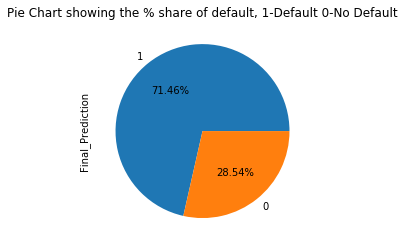

In [305]:
merged_open_df["Final_Prediction"].value_counts(normalize=True).plot.pie(autopct="%.2f%%")
plt.title("Pie Chart showing the % share of default, 1-Default 0-No Default")
plt.show()

In [306]:
merged_open_df.groupby("CUSTOMER_NAME")["Prob_Pred_rf"].mean().sort_values(ascending=False)


CUSTOMER_NAME
CUTE Corp    0.786742
IHSA Corp    0.785314
SAUD Corp    0.775537
MANS Corp    0.763689
AL M Corp    0.762998
               ...   
ST R Corp    0.238121
3D D Corp    0.237547
GROS Corp    0.234988
JUMB Corp    0.233212
ARMA Corp    0.217276
Name: Prob_Pred_rf, Length: 396, dtype: float64

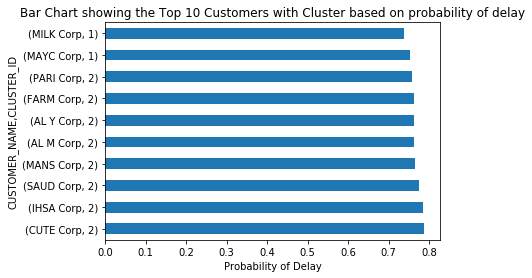

In [307]:
# Top 10 customers based on probability of delay with the customer segmentation cluster they belong
merged_open_df.groupby(["CUSTOMER_NAME","CLUSTER_ID"])["Prob_Pred_rf"].mean().sort_values(ascending=False).head(10).plot.barh()
plt.title("Bar Chart showing the Top 10 Customers with Cluster based on probability of delay")
plt.xlabel("Probability of Delay")
plt.show()

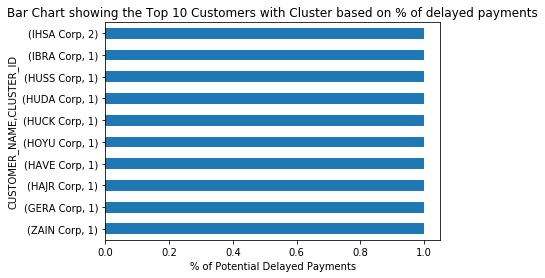

In [308]:
# Top 10 customers based on % of potential delays with the customer segmentation cluster they belong
merged_open_df.groupby(["CUSTOMER_NAME","CLUSTER_ID"])["Final_Prediction"].mean().sort_values(ascending=False).head(10).plot.barh()
plt.title("Bar Chart showing the Top 10 Customers with Cluster based on % of delayed payments")
plt.xlabel("% of Potential Delayed Payments")
plt.show()

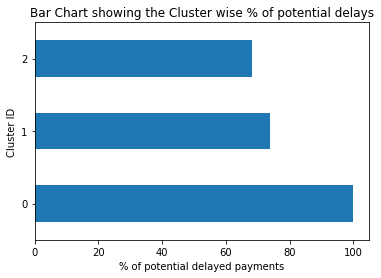

In [309]:
# Let us see the predictions cluster wise 
(merged_open_df.groupby(["CLUSTER_ID"])["Final_Prediction"].mean()*100).plot.barh()
plt.title("Bar Chart showing the Cluster wise % of potential delays")
plt.xlabel("% of potential delayed payments")
plt.ylabel("Cluster ID")
plt.show()

In [310]:
merged_open_df.groupby(["CLUSTER_ID"])["CUSTOMER_NAME"].nunique()


CLUSTER_ID
0      2
1    351
2     43
Name: CUSTOMER_NAME, dtype: int64

In [311]:
# Let us see the names of the customers in cluster 0 as there will 100% delays in these cases
merged_open_df[merged_open_df["CLUSTER_ID"]==0].groupby("CUSTOMER_NAME")["Prob_Pred_rf"].mean()

CUSTOMER_NAME
ALSU Corp    0.705776
NOUS Corp    0.678591
Name: Prob_Pred_rf, dtype: float64

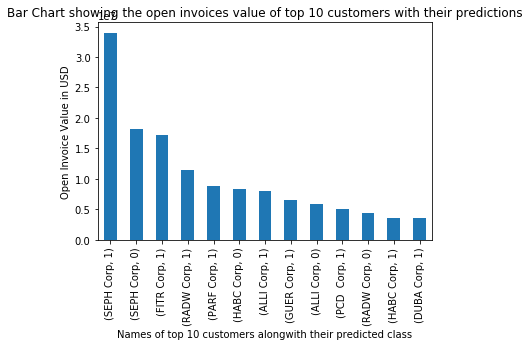

In [312]:
# Top 10 customers based on value of open invoices. Schuster needs to focus on those customers for whom Final Prediction is 1
merged_open_df.groupby(["CUSTOMER_NAME","Final_Prediction"])["USD Amount"].sum().sort_values(ascending=False).head(13).plot.bar()
plt.title("Bar Chart showing the open invoices value of top 10 customers with their predictions")
plt.xlabel("Names of top 10 customers alongwith their predicted class")
plt.ylabel("Open Invoice Value in USD")
plt.show() 

In [313]:
# Let us check the total number of open invoices customer wise
open_inv_count=merged_open_df.groupby("CUSTOMER_NAME")["Final_Prediction"].count()
open_inv_count=open_inv_count.to_frame()
open_inv_count.rename(columns={"Final_Prediction":"Number of Open Invoices"},inplace=True)
open_inv_count.head()

,Number of Open Invoices
CUSTOMER_NAME,
3D D Corp,30
6TH Corp,2
ABDU Corp,77
ABEE Corp,2
ABU Corp,5


In [314]:
# Let us check the % of predicted delayed invoices customer wise
open_inv_delay=merged_open_df.groupby("CUSTOMER_NAME")["Final_Prediction"].mean()
open_inv_delay=open_inv_delay.to_frame()
open_inv_delay.rename(columns={"Final_Prediction":"% of Predicted Delayed Invoices"},inplace=True)
open_inv_delay.head()

,% of Predicted Delayed Invoices
CUSTOMER_NAME,
3D D Corp,0.000000
6TH Corp,1.000000
ABDU Corp,0.805195
ABEE Corp,1.000000
ABU Corp,0.800000


In [315]:
# Merging the two, let us see how many invoices will be delayed in terms of volume
open_inv_customer=pd.merge(open_inv_count,open_inv_delay,how="inner",on="CUSTOMER_NAME")
open_inv_customer["Delayed Invoices Count"]=(open_inv_customer["Number of Open Invoices"]*open_inv_customer["% of Predicted Delayed Invoices"])
open_inv_customer.sort_values(by ="Delayed Invoices Count",ascending=False)

,Number of Open Invoices,% of Predicted Delayed Invoices,Delayed Invoices Count
CUSTOMER_NAME,,,
SEPH Corp,8260,0.660048,5452.0
FITR Corp,3454,0.866532,2993.0
PARF Corp,1717,0.845079,1451.0
AREE Corp,1117,0.482543,539.0
ALLI Corp,1042,0.435701,454.0
...,...,...,...
ST R Corp,3,0.000000,0.0
JIHA Corp,2,0.000000,0.0
J A Corp,1,0.000000,0.0


In [316]:
open_inv_customer.sort_values(by ="Delayed Invoices Count",ascending=False).head(10)

,Number of Open Invoices,% of Predicted Delayed Invoices,Delayed Invoices Count
CUSTOMER_NAME,,,
SEPH Corp,8260,0.660048,5452.0
FITR Corp,3454,0.866532,2993.0
PARF Corp,1717,0.845079,1451.0
AREE Corp,1117,0.482543,539.0
ALLI Corp,1042,0.435701,454.0
HABC Corp,517,0.738878,382.0
AL T Corp,584,0.578767,338.0
DEBE Corp,654,0.481651,315.0
RADW Corp,490,0.589796,289.0


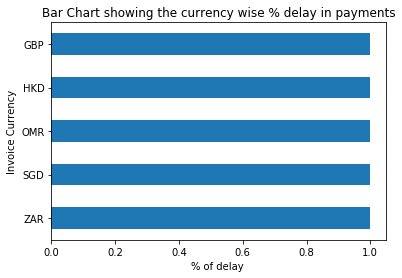

In [317]:
# Top 5 currencies where there is 100% delay
merged_open_df.groupby(["INVOICE_CURRENCY_CODE"])["Final_Prediction"].mean().sort_values(ascending=False).head().plot.barh()
plt.title("Bar Chart showing the currency wise % delay in payments")
plt.xlabel("% of delay ")
plt.ylabel("Invoice Currency")
plt.show()

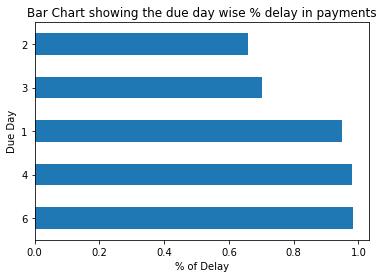

In [318]:
# Almost 100 % delay where Due day is Friday or sunday
merged_open_df.groupby(["DUE_DAY"])["Final_Prediction"].mean().sort_values(ascending=False).head().plot.barh()
plt.title("Bar Chart showing the due day wise % delay in payments")
plt.xlabel("% of Delay")
plt.ylabel("Due Day")
plt.show()

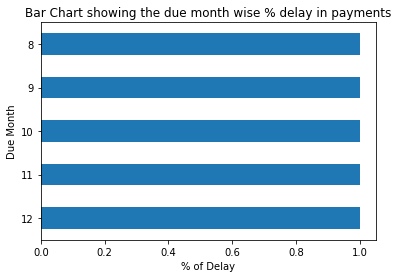

In [319]:
merged_open_df.groupby(["DUE_MONTH"])["Final_Prediction"].mean().sort_values(ascending=False).head().plot.barh()
plt.title("Bar Chart showing the due month wise % delay in payments")
plt.xlabel("% of Delay")
plt.ylabel("Due Month")
plt.show()

In [320]:
# Invoices due in March,Jul-Oct will require more followup for timely payments.

#### Points to Note
    - Focus on Cluster 0 it has prolonged delays
    - Dedicte people for follow up as volume of invoices is huge
    - Invoices due in Mar , Jul-Oct and due on Friday and Sunday have higher chances of default
    - Invoicing currency is ZAR,HKD,SGD,OMR and GBP should also be kept and eye on
    - SEPH, FITR, PARF should be checked as their Delay invoice count is high

## Thank You